**Notebook used to make particle-level lepton evaluation plots**

Main diff between this notebook and `cmssw-validation-particles` is that this script adds missing leptons that are part of the`GenPart` collections but were skimmed during NANOAOD conversion: `GenPart -> GenCands`

In [1]:
import os, sys
import uproot
import awkward as ak
import vector
import numpy as np
vector.register_awkward()

import boost_histogram as bh
import numba
import mplhep
import sklearn
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

mplhep.set_style(mplhep.styles.CMS)

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_15066/3051392346.py:17: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  mplhep.set_style(mplhep.styles.CMS)


In [2]:
sys.path += ["../../mlpf/plotting//"]
from plot_utils import EVALUATION_DATASET_NAMES, experiment_label
from plot_utils import SAMPLE_LABEL_CMS, pid_to_text, EXPERIMENT_LABELS

In [3]:
def sample_label(ax, sample, additional_text="", x=0.03, y=0.97, fontsize=20):
    text = EVALUATION_DATASET_NAMES[sample]
    plt.text(x, y, text + additional_text, ha="left", va="top", transform=ax.transAxes, fontsize=fontsize)

def cms_label(ax):
    return experiment_label(ax, experiment="CMS", tag1=" Simulation Preliminary", tag2="Run 3 (14 TeV)", x1=0.13)

In [4]:
@numba.njit
def deltaphi(phi1, phi2):
    diff = phi1 - phi2
    return np.arctan2(np.sin(diff), np.cos(diff))

@numba.njit
def deltar(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = deltaphi(phi1, phi2)
    return np.sqrt(deta**2 + dphi**2)

@numba.njit
def match_particles(eta1, eta2, phi1, phi2, deltaR_cut):
    nev = len(eta1)
    ptcl_inds_1_ev = []
    ptcl_inds_2_ev = []
    best_drs_ev = []
    for iev in range(nev):
        ptcl_inds_1 = []
        ptcl_inds_2 = []
        best_drs = []

        # loop over the first collection
        pfs_used = np.zeros(len(eta2[iev]))
        for ip1 in range(len(eta1[iev])):
            # compute deltaR from this particle to all particles in the other collection
            drs = 999*np.ones(len(eta2[iev]), dtype=np.float64)

            # loop over the second collection
            for ip2 in range(len(eta2[iev])):
                if pfs_used[ip2]==1:
                    continue
                _eta1 = eta1[iev][ip1]
                _eta2 = eta2[iev][ip2]
                _phi1 = phi1[iev][ip1]
                _phi2 = phi2[iev][ip2]

                dr = deltar(_eta1, _phi1, _eta2, _phi2)
                drs[ip2] = dr

            if len(drs) > 0:
                # find closest match to this particle
                min_idx_dr = np.argmin(drs)

                # has to be closer than the deltaR_cut
                if drs[min_idx_dr] < deltaR_cut:
                    ptcl_inds_1.append(ip1)
                    ptcl_inds_2.append(min_idx_dr)
                    best_drs.append(drs[min_idx_dr])
                    pfs_used[min_idx_dr] = 1
                
        ptcl_inds_1_ev.append(ptcl_inds_1)
        ptcl_inds_2_ev.append(ptcl_inds_2)
        best_drs_ev.append(best_drs)
    return ptcl_inds_1_ev, ptcl_inds_2_ev, best_drs_ev

def sum_overflow_into_last_bin(all_values):
    values = all_values[1:-1]
    values[-1] = values[-1] + all_values[-1]
    values[0] = values[0] + all_values[0]
    return values
    
def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    h1[:] = sum_overflow_into_last_bin(h1.values(flow=True)[:])
    return h1

def binom_error(n_sig, n_tot):
    """
    for an efficiency = nSig/nTrueSig or purity = nSig / (nSig + nBckgrd), this function calculates the
    standard deviation according to http://arxiv.org/abs/physics/0701199 .
    """
    variance = np.where(
        n_tot > 0, (n_sig + 1) * (n_sig + 2) / ((n_tot + 2) * (n_tot + 3)) - (n_sig + 1) ** 2 / ((n_tot + 2) ** 2), 0
    )
    return np.sqrt(variance)

def midpoints(x):
    return (x[1:] + x[:-1]) / 2

In [5]:
! ls ../../data/CMSSW_15_0_5_mlpf_v2.5.0_p04/

QCD_noPU_mlpfpu   TTbar_noPU_mlpfpu TTbar_PU_mlpfpu
QCD_noPU_pf       TTbar_noPU_pf


In [6]:
! ls ../../data/CMSSW_15_0_5_mlpf_v2.5.0_p04/TTbar_noPU_mlpfpu/

step4_NANO_btv_1.root step4_NANO_btv_4.root step4_NANO_btv_7.root
step4_NANO_btv_2.root step4_NANO_btv_5.root step4_NANO_btv_8.root
step4_NANO_btv_3.root step4_NANO_btv_6.root step4_NANO_btv_9.root


In [7]:
dataset = "cms"

save_as = {
    "cms_pf_qcd_nopu": "QCD_noPU",
    "cms_pf_ttbar_nopu": "TTbar_noPU",
}
nfiles = {
    "cms_pf_qcd_nopu": 50,
    "cms_pf_ttbar_nopu": 7,
}

GenPart_fields = [
    "GenPart_pt", "GenPart_eta", "GenPart_phi", "GenPart_mass", "GenPart_pdgId", "GenPart_status", "GenPart_genPartIdxMother",
]
GenCand_fields = [
    "GenCands_pt", "GenCands_eta", "GenCands_phi", "GenCands_mass", "GenCands_pdgId", "GenCands_charge",
]
PFCand_fields = [
    "PFCands_pt", "PFCands_eta", "PFCands_phi", "PFCands_mass", "PFCands_pdgId",
]
vELE_PDGID = 12
vMU_PDGID = 14
vTAU_PDGID = 16

In [8]:
##### specify the sample to use
sample = "cms_pf_ttbar_nopu"
# sample = "cms_pf_qcd_nopu"

data_pfs = []
data_mlpfs = []

for ifile in range(1,nfiles[sample]):
    print(ifile)
    ev_pf = uproot.open(f"../../data/CMSSW_15_0_5_mlpf_v2.5.0_p04/{save_as[sample]}_pf/step4_NANO_btv_{ifile}.root").get("Events")
    ev_mlpf = uproot.open(f"../../data/CMSSW_15_0_5_mlpf_v2.5.0_p04/{save_as[sample]}_mlpfpu/step4_NANO_btv_{ifile}.root").get("Events")
    
    ############# pf
    data_pf = ev_pf.arrays(
        GenPart_fields + GenCand_fields + PFCand_fields
    )
    
    # apply status cuts on genpart
    msk_status = (data_pf["GenPart_status"] == 1)
    msk_nu = ((abs(data_pf["GenPart_pdgId"]) != vELE_PDGID) | (abs(data_pf["GenPart_pdgId"]) != vMU_PDGID) | (abs(data_pf["GenPart_pdgId"]) != vTAU_PDGID))
    for key in GenPart_fields:
        if "GenPart_status" in key:
            continue
        if "GenPart_pdgId" in key:
            continue            
        data_pf[key] = data_pf[key][msk_status & msk_nu]
    data_pf["GenPart_pdgId"] = data_pf["GenPart_pdgId"][msk_status & msk_nu]
    
    data_pfs.append(data_pf)
    
    ############# mlpf
    data_mlpf = ev_mlpf.arrays(
        GenPart_fields + GenCand_fields + PFCand_fields
    )
    
    # apply status cuts on genpart    
    msk_status = (data_mlpf["GenPart_status"] == 1)
    msk_nu = ((abs(data_mlpf["GenPart_pdgId"]) != vELE_PDGID) | (abs(data_mlpf["GenPart_pdgId"]) != vMU_PDGID) | (abs(data_mlpf["GenPart_pdgId"]) != vTAU_PDGID))
    for key in GenPart_fields:
        if "GenPart_status" in key:
            continue
        if "GenPart_pdgId" in key:
            continue            
        data_mlpf[key] = data_mlpf[key][msk_status & msk_nu]
    data_mlpf["GenPart_pdgId"] = data_mlpf["GenPart_pdgId"][msk_status & msk_nu]
        
    data_mlpfs.append(data_mlpf)

1
2
3
4
5
6


In [9]:
data_pf = ak.concatenate(data_pfs)
data_mlpf = ak.concatenate(data_mlpfs)

In [10]:
import particle
from particle import Particle
from particle import PDGID # https://github.com/scikit-hep/particle

def remap_pid_GenCands(data):
    """
    Gen does not have HF so must remap Reco HF to ch.had or n.had
    """
    pid = np.abs(np.asarray(ak.flatten(data["GenCands_pdgId"])))
    pa = ak.flatten(np.abs(data["GenCands_pdgId"]))
    pc = ak.flatten(np.abs(data["GenCands_charge"]))
    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==1)] = 211
    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==0)] = 130
    data["GenCands_pid"] = ak.unflatten(pid, ak.count(data["GenCands_pdgId"], axis=1))
    data["PFCands_pid"] = np.abs(data["PFCands_pdgId"])

remap_pid_GenCands(data_pf)
remap_pid_GenCands(data_mlpf)

def get_charge_array(pdgids):
    
    ret = []
    for pid in pdgids:
        try:
            p = Particle.from_pdgid(pid)
#             print(f"PDG ID {pid}: {p.name}, charge = {p.charge}")
            ret += [p.charge]
        except Exception as e:
            print(f"PDG ID {pid}: not found")  
            ret += [np.nan]
    
    return ak.Array(ret)
        
def remap_pid_GenParts(data):
    """
    Gen does not have HF so must remap Reco HF to ch.had or n.had
    """
    pid = np.abs(np.asarray(ak.flatten(data["GenPart_pdgId"])))
    
    pa = ak.flatten(np.abs(data["GenPart_pdgId"]))
    pc = np.abs(get_charge_array(ak.flatten(data["GenPart_pdgId"])))

    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==1)] = 211
    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==0)] = 130
    data["GenPart_pid"] = ak.unflatten(pid, ak.count(data["GenPart_pdgId"], axis=1))
    data["PFCands_pid"] = np.abs(data["PFCands_pdgId"])

remap_pid_GenParts(data_pf)
remap_pid_GenParts(data_mlpf)

# Visualize in dR the need to add back the missing particles

In [11]:
os.makedirs(f"./plots/{save_as[sample]}/missing_genmuons", exist_ok=True)

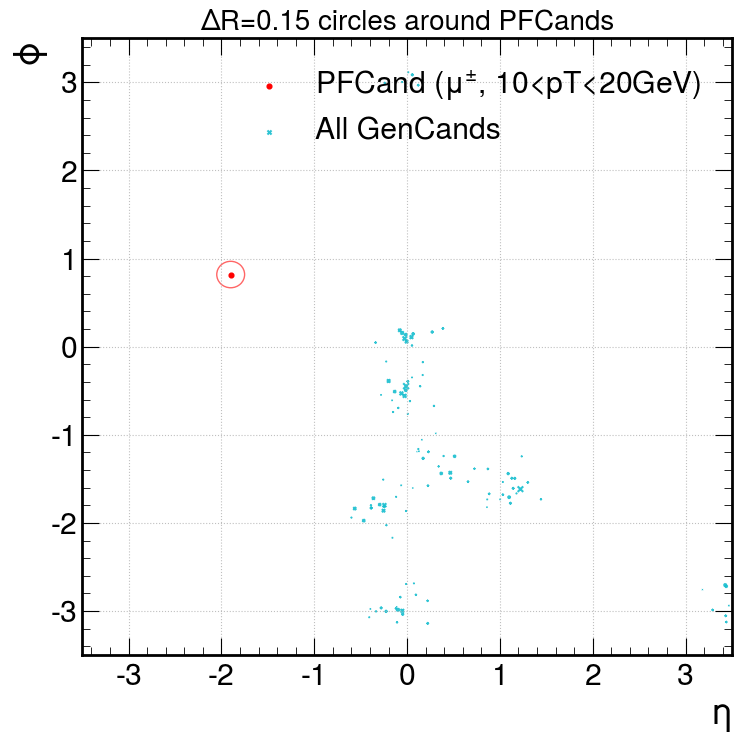

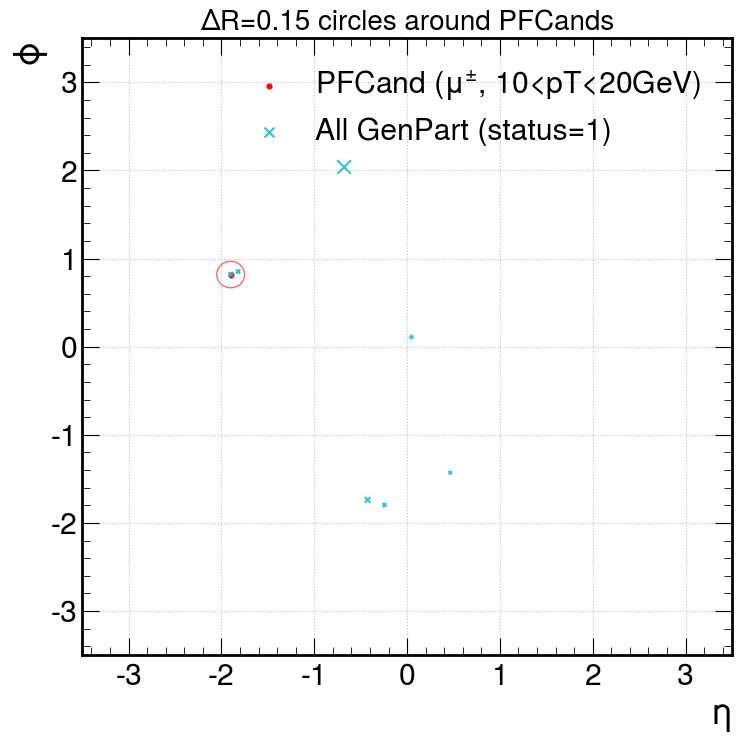

In [12]:
dr_circle_size = 0.15   ###### specify dR threshold
pid = 13
pt_ = (10,20)

bad_events = [
    47, 
#     111, 
#     147,
#     156,
]

for iev in range(200):
    
    if iev not in bad_events:
        continue

    msk_pid_reco = data_pf["PFCands_pid"] == pid
    eta_vals = data_pf["PFCands_eta"][msk_pid_reco][iev]
    phi_vals = data_pf["PFCands_phi"][msk_pid_reco][iev]
    pt_vals  = data_pf["PFCands_pt"][msk_pid_reco][iev]

    eta_vals = eta_vals[(pt_vals>pt_[0]) & (pt_vals<pt_[1])]
    phi_vals = phi_vals[(pt_vals>pt_[0]) & (pt_vals<pt_[1])]
    pt_vals = pt_vals[(pt_vals>pt_[0]) & (pt_vals<pt_[1])]

    if len(pt_vals) == 0:
        continue
    
    ############ GenCands
    plt.figure(figsize=(8,8))
    ax = plt.gca()  # Get the current axis to add patches
    plt.scatter(eta_vals, phi_vals, s=pt_vals, color='red', label=f'PFCand ({pid_to_text[pid]}, {pt_[0]}<pT<{pt_[1]}GeV)')
    # Draw ΔR=0.1 cones
    for eta, phi in zip(eta_vals, phi_vals):
        circle = Circle((eta, phi), dr_circle_size, color='red', alpha=0.6, fill=False, linewidth=1)
        ax.add_patch(circle)
    plt.scatter(data_pf["GenCands_eta"][iev], data_pf["GenCands_phi"][iev], s=data_pf["GenCands_pt"][iev], marker="x", color="tab:cyan", alpha=0.9, label="All GenCands")
    plt.xlim(-3.5, 3.5)
    plt.ylim(-3.5, 3.5)
    plt.xlabel("η")
    plt.ylabel("ϕ")
    plt.legend()
    plt.title(f"ΔR={dr_circle_size} circles around PFCands", fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"./plots/{save_as[sample]}/missing_genmuons/muons_gencands_{iev}.pdf")
    
    ############ GenPart
    plt.figure(figsize=(8,8))
    ax = plt.gca()  # Get the current axis to add patches
    plt.scatter(eta_vals, phi_vals, s=pt_vals, color='red', label=f'PFCand ({pid_to_text[pid]}, {pt_[0]}<pT<{pt_[1]}GeV)')
    # Draw ΔR=0.1 cones
    for eta, phi in zip(eta_vals, phi_vals):
        circle = Circle((eta, phi), dr_circle_size, color='red', alpha=0.6, fill=False, linewidth=1)
        ax.add_patch(circle)
    msk_pt = (data_pf["GenPart_pt"]>5)
    plt.scatter(data_pf["GenPart_eta"][msk_pt][iev], data_pf["GenPart_phi"][msk_pt][iev], s=data_pf["GenPart_pt"][msk_pt][iev], marker="x", color="tab:cyan", alpha=0.9, label="All GenPart (status=1)")
    plt.xlim(-3.5, 3.5)
    plt.ylim(-3.5, 3.5)
    plt.xlabel("η")
    plt.ylabel("ϕ")
    plt.legend()
    plt.title(f"ΔR={dr_circle_size} circles around PFCands", fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"./plots/{save_as[sample]}/missing_genmuons/muons_parts_{iev}.pdf")

# Add missing GenPart

In [13]:
def add_missing_genpart(data, dR_threshold=0.15):

    """Returns a `Gen_p4` branch that has ``GenCands` and additional `GenPart` that were missing."""

    msk_genpart = (data["GenPart_pt"]>0.5)
    genparts = ak.zip({
        "pt": data["GenPart_pt"][msk_genpart],
        "eta": data["GenPart_eta"][msk_genpart],
        "phi": data["GenPart_phi"][msk_genpart],
        "mass": data["GenPart_mass"][msk_genpart],
        "pid": data["GenPart_pid"][msk_genpart],        
    }, with_name="Momentum4D")

    msk_gencands = (data["GenCands_pt"]>0.5)
    gencands = ak.zip({
        "pt": data["GenCands_pt"][msk_gencands],
        "eta": data["GenCands_eta"][msk_gencands],
        "phi": data["GenCands_phi"][msk_gencands],
        "mass": data["GenCands_mass"][msk_gencands],
    }, with_name="Momentum4D")

    # Compute all (genpart, gencand) combinations per event
    pairs = ak.cartesian([genparts, gencands], axis=1, nested=True)
    genpart_matched = pairs["0"]
    gencand_matched = pairs["1"]

    # Compute deltaR per pair
    deltaR = genpart_matched.deltaR(gencand_matched)

    # For each GenPart, determine if all deltaR > 0.15 (i.e., no nearby GenCand)
    no_match = ak.all(deltaR > dR_threshold, axis=2)

    # Filter GenPart fields based on no_match
    filtered_genpart = {
        key: data[f"GenPart_{key}"][msk_genpart][no_match]
        for key in ["pt", "eta", "phi", "pid", "mass"]
    }

    # Concatenate unmatched GenParts with all GenCands
    for key in ["pt", "eta", "phi", "pid", "mass"]:
        data[f"Gen_{key}"] = ak.concatenate(
            [filtered_genpart[key], data[f"GenCands_{key}"]], axis=1
        )
    return data

In [14]:
dR_threshold = 0.15
data_pf = add_missing_genpart(data_pf, dR_threshold=dR_threshold)
data_mlpf = add_missing_genpart(data_mlpf, dR_threshold=dR_threshold)

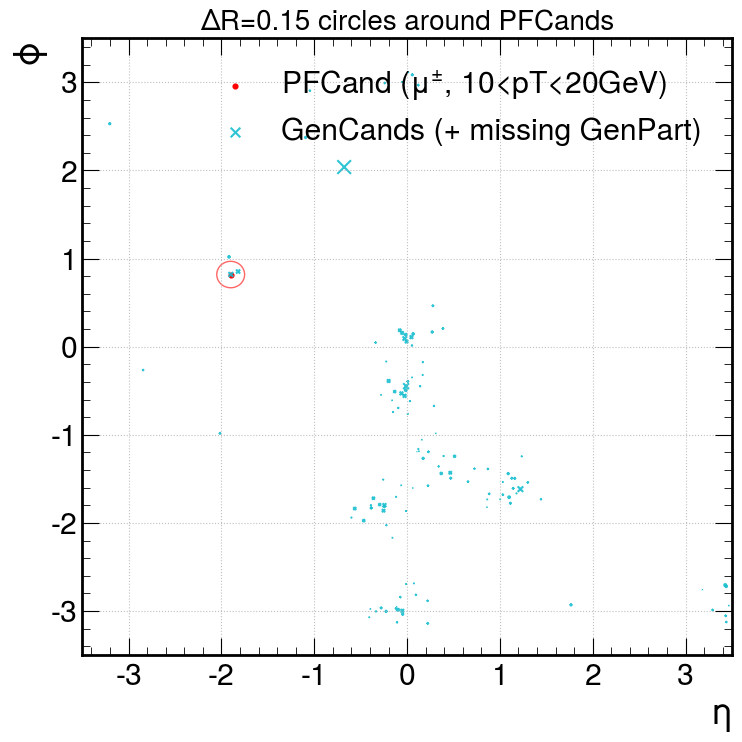

In [15]:
dr_circle_size = 0.15   ###### specify dR threshold
pid = 13
pt_ = (10,20)

bad_events = [
    47, 
#     111, 
#     147, 
#     156,
]

for iev in range(200):
    
    if iev not in bad_events:
        continue

    msk_pid_reco = data_pf["PFCands_pid"] == pid
    eta_vals = data_pf["PFCands_eta"][msk_pid_reco][iev]
    phi_vals = data_pf["PFCands_phi"][msk_pid_reco][iev]
    pt_vals  = data_pf["PFCands_pt"][msk_pid_reco][iev]

    eta_vals = eta_vals[(pt_vals>pt_[0]) & (pt_vals<pt_[1])]
    phi_vals = phi_vals[(pt_vals>pt_[0]) & (pt_vals<pt_[1])]
    pt_vals = pt_vals[(pt_vals>pt_[0]) & (pt_vals<pt_[1])]

    if len(pt_vals) == 0:
        continue
    
    ############ GenPart
    plt.figure(figsize=(8,8))
    ax = plt.gca()  # Get the current axis to add patches
    plt.scatter(eta_vals, phi_vals, s=pt_vals, color='red', label=f'PFCand ({pid_to_text[pid]}, {pt_[0]}<pT<{pt_[1]}GeV)')
    # Draw ΔR=0.1 cones
    for eta, phi in zip(eta_vals, phi_vals):
        circle = Circle((eta, phi), dr_circle_size, color='red', alpha=0.6, fill=False, linewidth=1)
        ax.add_patch(circle)
    plt.scatter(data_pf["Gen_eta"][iev], data_pf["Gen_phi"][iev], s=data_pf["Gen_pt"][iev], marker="x", color="tab:cyan", alpha=0.9, label="GenCands (+ missing GenPart)")
    plt.xlim(-3.5, 3.5)
    plt.ylim(-3.5, 3.5)
    plt.xlabel("η")
    plt.ylabel("ϕ")
    plt.legend()
    plt.title(f"ΔR={dr_circle_size} circles around PFCands", fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"./plots/{save_as[sample]}/missing_genmuons/muons_gencands_plus_missing_genpart_{iev}.pdf")

# Make particle-level plots

In [16]:
color_code = {
    "Gen": "tab:blue",
    "PF": "tab:orange",
    "MLPF": "tab:red",
}

In [17]:
bins_pt = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(0,500,41),
        130: np.linspace(0,200,41),
        22: np.linspace(0,200,41),
        11: np.linspace(0,50,21),
        13: np.linspace(0,50,21),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(0,60,31),
        130: np.linspace(0,40,31),
        22: np.linspace(0,40,31),
        11: np.linspace(0,100,31),
        13: np.linspace(0,100,31),
    },  
}

bins_eta = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(-2.5,2.5,41),
        130: np.linspace(-3,3,41),
        22: np.linspace(-3,3,41),
        11: np.linspace(-2.5,2.5,41),
        13: np.linspace(-2.5,2.5,41),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(-2.5,2.5,41),
        130: np.linspace(-3,3,41),
        22: np.linspace(-3,3,41),
        11: np.linspace(-2.5,2.5,41),
        13: np.linspace(-2.5,2.5,41),
    },
}

bins_phi = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(-3,3,41),
        130: np.linspace(-3,3,41),
        22: np.linspace(-3,3,41),
        11: np.linspace(-3,3,41),
        13: np.linspace(-3,3,41),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(-3,3,41),
        130: np.linspace(-3,3,41),
        22: np.linspace(-3,3,41),
        11: np.linspace(-3,3,21),
        13: np.linspace(-3,3,21),
    },  
}

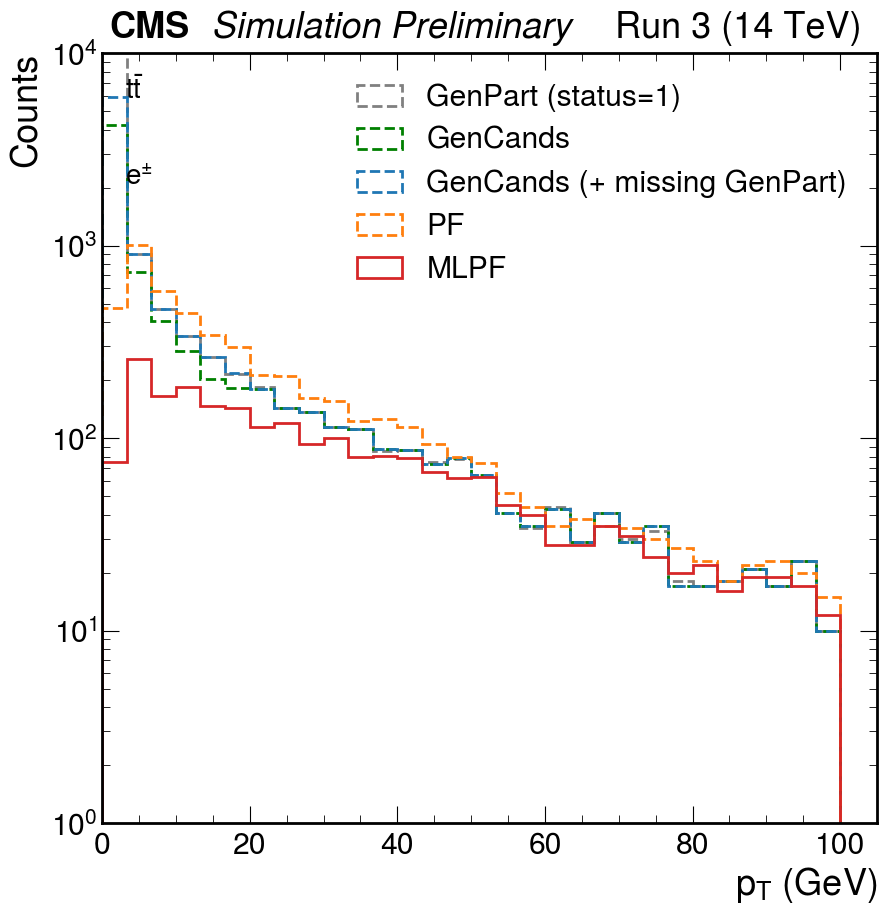

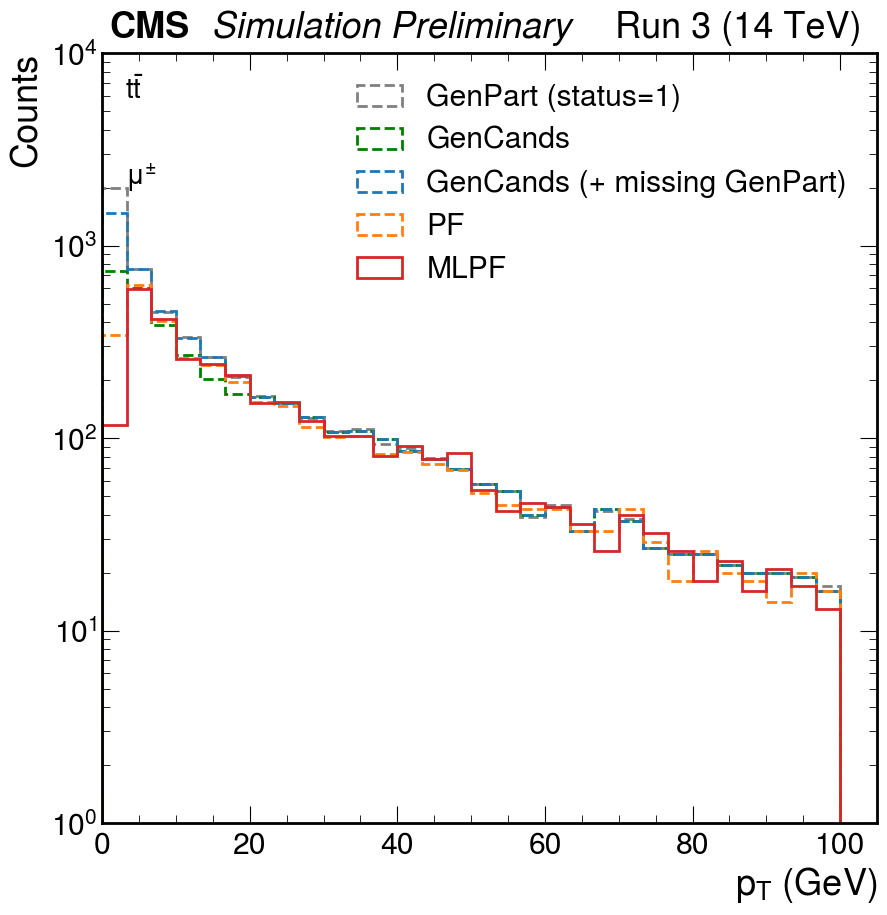

In [18]:
ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: 10**8,
        130: 10**7,
        22: 10**8,
        11: 10**6,
        13: 10**4,
    },  
    "cms_pf_ttbar_nopu": {
        211: 10**7,
        130: 10**6,
        22: 10**6,
        11: 10**4,
        13: 10**4,
    },    
}

for pid in [
#     211,
#     130,
#     22,
    11,
    13,
]:
    fig, ax = plt.subplots(
        figsize=(10, 10),
    )

    # Extract flattened arrays
    sel = data_pf["GenCands_pid"] == pid
    X_gencands = ak.to_numpy(ak.flatten(data_pf["GenCands_pt"][sel]))
    
    sel = data_pf["GenPart_pid"] == pid
    X_genpart = ak.to_numpy(ak.flatten(data_pf["GenPart_pt"][sel]))
    
    sel = data_pf["Gen_pid"] == pid
    X_gen = ak.to_numpy(ak.flatten(data_pf["Gen_pt"][sel]))

    sel = data_pf["PFCands_pid"] == pid
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_pt"][sel]))

    sel = data_mlpf["PFCands_pid"] == pid
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_pt"][sel]))

    bins = bins_pt[sample][pid]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])

    # Histograms
    h_gencands, _ = np.histogram(X_gencands, bins=bins)
    h_genpart, _ = np.histogram(X_genpart, bins=bins)    
    h_gen, _ = np.histogram(X_gen, bins=bins)
    h_pf, _ = np.histogram(X_pf, bins=bins)
    h_mlpf, _ = np.histogram(X_mlpf, bins=bins)

    # Main plot
    ax.hist(bins[:-1], bins=bins, weights=h_genpart, histtype="step", lw=2, label="GenPart (status=1)", linestyle="--", color="grey")        
    ax.hist(bins[:-1], bins=bins, weights=h_gencands, histtype="step", lw=2, label="GenCands", linestyle="--", color="green")
    ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="GenCands (+ missing GenPart)", linestyle="--", color=color_code["Gen"])
    ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
    ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

    ax.set_yscale("log")
    ax.set_ylabel("Counts")
    ax.set_ylim(1, ylim_dict[sample][pid])
    ax.set_xlim(0)
    ax.legend()
    cms_label(ax)
    sample_label(ax, sample)
    plt.text(0.03, 0.83, pid_to_text[pid], transform=ax.transAxes, fontsize=20)

    ax.set_xlabel("$p_T$ (GeV)")

    plt.savefig(f"./plots/{save_as[sample]}/particle_pt_dist/{sample}_pt_{pid}_ANcheck.pdf")

# pT

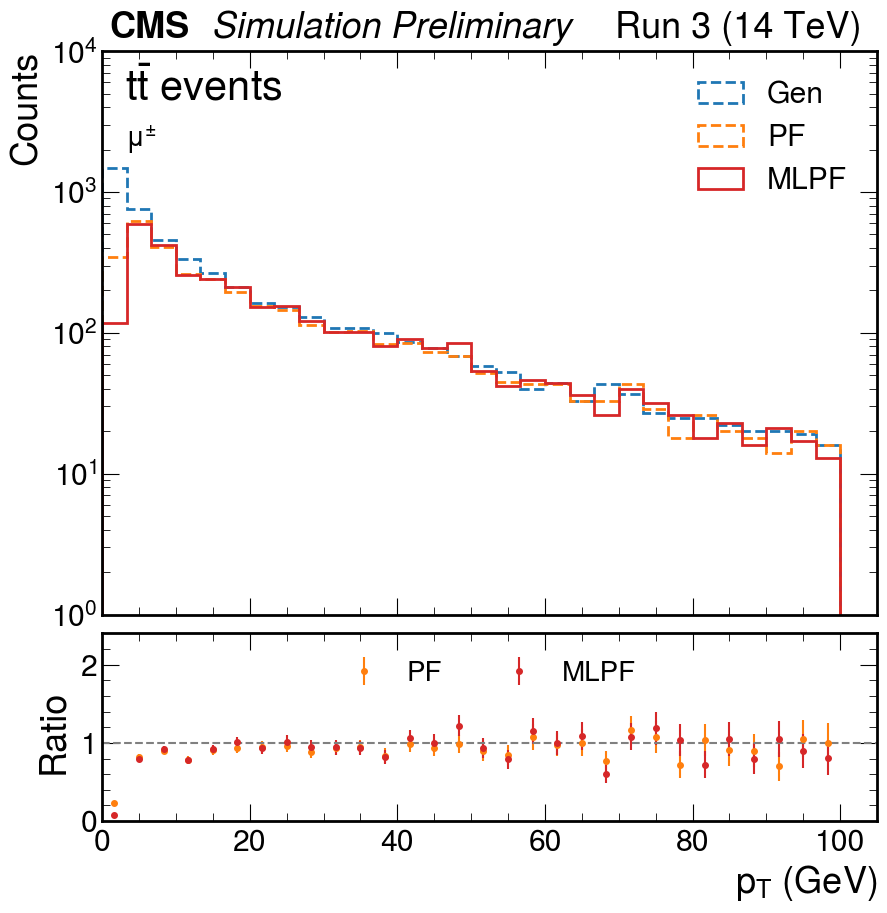

In [19]:
ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: 10**7,
        130: 10**6,
        22: 10**7,
        11: 10**7,
        13: 10**6,
    },
    "cms_pf_ttbar_nopu": {
        211: 10**7,
        130: 10**6,
        22: 10**7,
        11: 10**5,
        13: 10**4,
    },    
}

rax_ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: (0,2.8),
        130: (0,2.2),
        22: (0,3),
        11: (0,8),
        13: (0,4),
    },
    "cms_pf_ttbar_nopu": {
        211: (0.5,1.5),
        130: (0,2),
        22: (0,2.5),
        11: (0,3),
        13: (0,2.4),
    },    
}

for pid in [
#     211,
#     130,
#     22,
    11,
    13,
]:
    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 10), sharex=True,
        gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
    )

    # Extract flattened arrays
    sel = data_pf["Gen_pid"] == pid
    X_gen = ak.to_numpy(ak.flatten(data_pf["Gen_pt"][sel]))

    sel = data_pf["PFCands_pid"] == pid
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_pt"][sel]))

    sel = data_mlpf["PFCands_pid"] == pid
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_pt"][sel]))

    bins = bins_pt[sample][pid]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])

    # Histograms
    h_gen, _ = np.histogram(X_gen, bins=bins)
    h_pf, _ = np.histogram(X_pf, bins=bins)
    h_mlpf, _ = np.histogram(X_mlpf, bins=bins)

    # Main plot
    ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
    ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
    ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

    ax.set_yscale("log")
    ax.set_ylabel("Counts")
    ax.set_ylim(1, ylim_dict[sample][pid])
    ax.set_xlim(0)
    ax.legend()
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.83, pid_to_text[pid], transform=ax.transAxes, fontsize=20)

    # Ratio + error bars
    ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
    ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

    # Error bars: Poisson error propagation
    err_pf = np.sqrt(h_pf) / h_gen
    err_mlpf = np.sqrt(h_mlpf) / h_gen
    err_pf[h_gen == 0] = np.nan
    err_mlpf[h_gen == 0] = np.nan

    rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
    rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

    rax.axhline(1.0, color="gray", linestyle="--")
    rax.set_ylim(rax_ylim_dict[sample][pid])
    rax.set_ylabel("Ratio")
    
    rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates
    
    rax.set_xlabel("$p_T$ (GeV)")
    rax.legend(fontsize=20, ncol=2, loc="upper center")

    plt.savefig(f"./plots/{save_as[sample]}/particle_pt_dist/{sample}_pt_{pid}_with_missing_genparts.pdf")

# eta

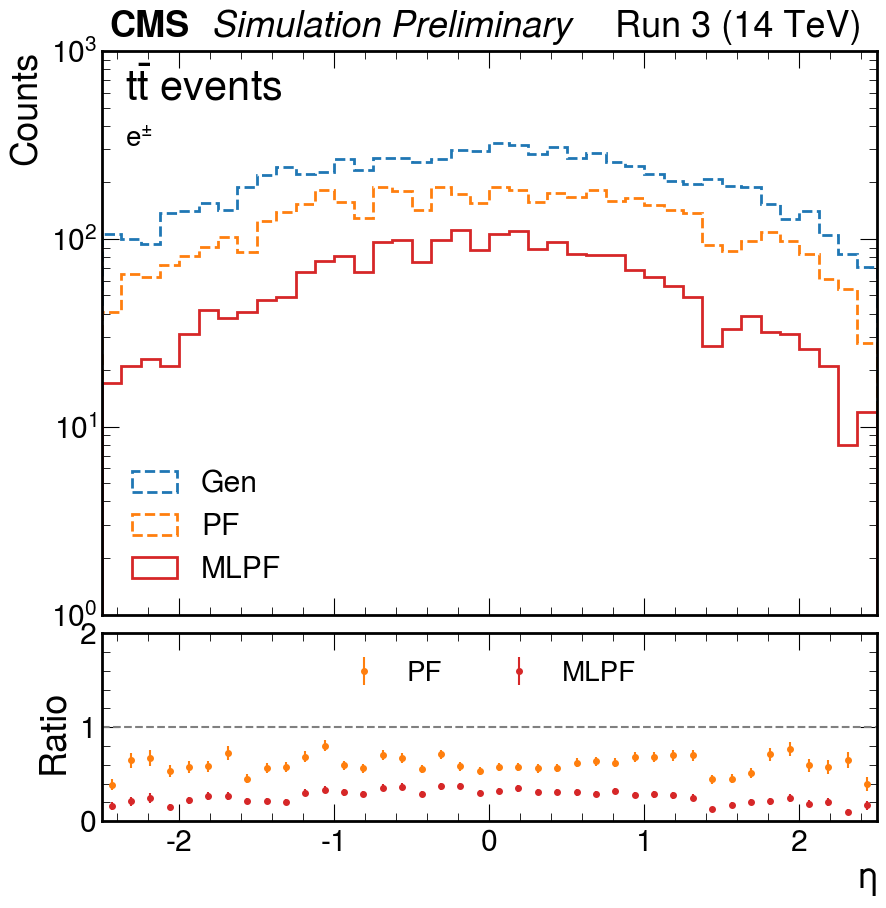

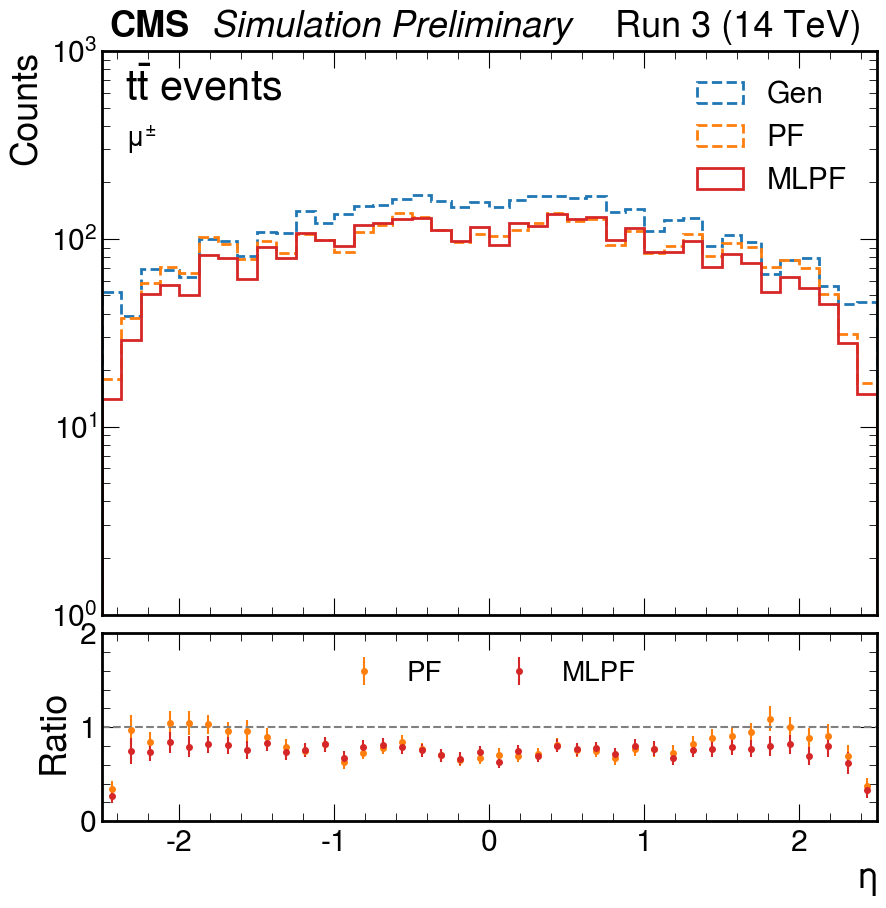

In [20]:
ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: 10**7,
        130: 10**6,
        22: 10**7,
        11: 10**4,
        13: 10**3,
    },    
    "cms_pf_ttbar_nopu": {
        211: 10**6,
        130: 10**5,
        22: 10**5,
        11: 10**3,
        13: 10**3,
    },    
}

rax_ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: (0.5,1.5),
        130: (0.5,1.5),
        22: (0,2),
        11: (0,2),
        13: (0,3),
    },    
    "cms_pf_ttbar_nopu": {
        211: (0.8,1.2),
        130: (0.4,1.6),
        22: (0,2),
        11: (0,2),
        13: (0,2),
    },    
}

for pid in [
#     211,
#     130,
#     22,
    11,
    13,
]:
    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 10), sharex=True,
        gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
    )

    # Extract flattened arrays
    sel = data_pf["Gen_pid"] == pid
    X_gen = ak.to_numpy(ak.flatten(data_pf["Gen_eta"][sel]))

    sel = data_pf["PFCands_pid"] == pid
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_eta"][sel]))

    sel = data_mlpf["PFCands_pid"] == pid
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_eta"][sel]))

    bins = bins_eta[sample][pid]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])

    # Histograms
    h_gen, _ = np.histogram(X_gen, bins=bins)
    h_pf, _ = np.histogram(X_pf, bins=bins)
    h_mlpf, _ = np.histogram(X_mlpf, bins=bins)

    # Main plot
    ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
    ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
    ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

    ax.set_yscale("log")
    ax.set_ylabel("Counts")
    ax.set_ylim(1, ylim_dict[sample][pid])
    ax.set_xlim(-3,3)
    ax.legend()
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.83, pid_to_text[pid], transform=ax.transAxes, fontsize=20)

    # Ratio + error bars
    ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
    ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

    # Error bars: Poisson error propagation
    err_pf = np.sqrt(h_pf) / h_gen
    err_mlpf = np.sqrt(h_mlpf) / h_gen
    err_pf[h_gen == 0] = np.nan
    err_mlpf[h_gen == 0] = np.nan

    rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
    rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

    rax.axhline(1.0, color="gray", linestyle="--")
    rax.set_ylim(rax_ylim_dict[sample][pid])
    rax.set_ylabel("Ratio")

    rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates
            
    rax.set_xlabel(r"$\eta$")
    plt.xlim(-2.5, 2.5)
    rax.legend(fontsize=20, ncol=2, loc="upper center")

    plt.savefig(f"./plots/{save_as[sample]}/particle_eta_dist/{sample}_eta_{pid}_with_missing_genparts.pdf")

# phi

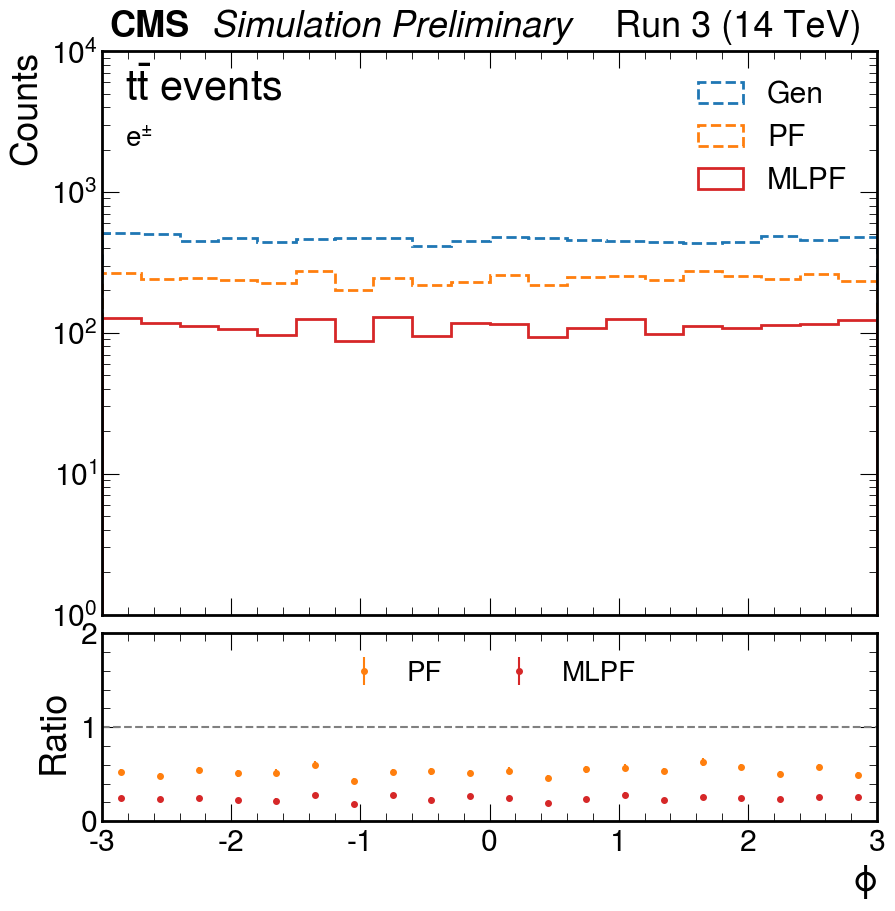

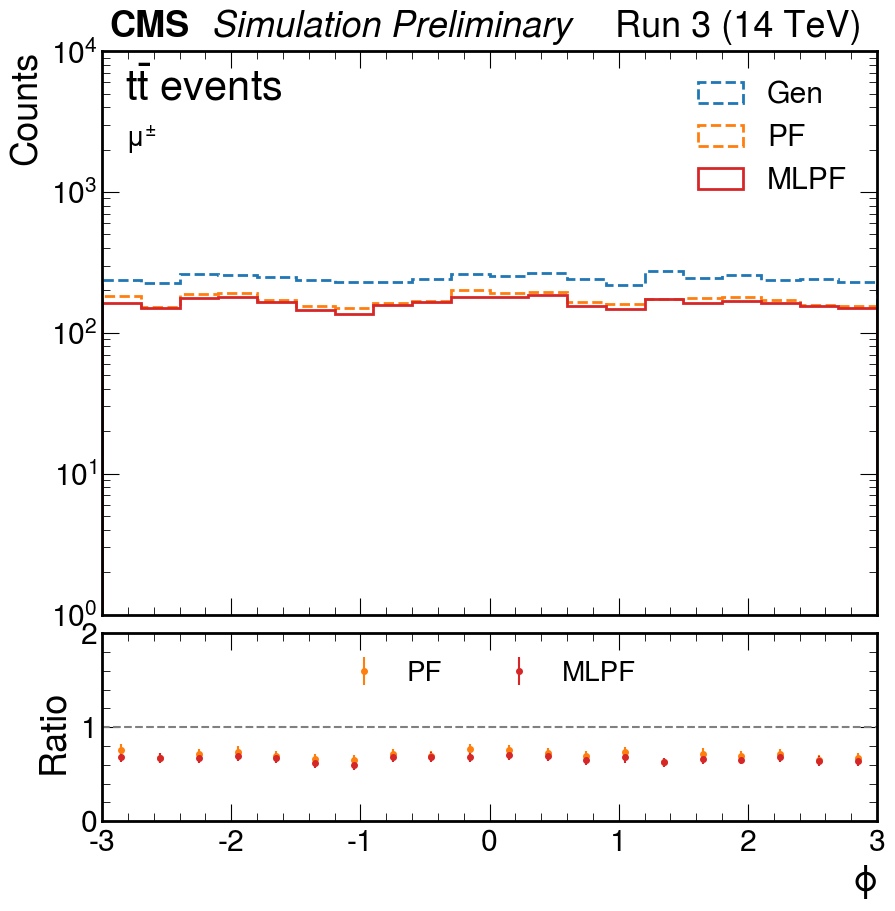

In [21]:
ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: 10**7,
        130: 10**6,
        22: 10**7,
        11: 10**6,
        13: 10**5,
    },    
    "cms_pf_ttbar_nopu": {
        211: 10**6,
        130: 10**5,
        22: 10**5,
        11: 10**4,
        13: 10**4,
    },    
}

rax_ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: (0.5,1.5),
        130: (0.5,1.5),
        22: (0,2),
        11: (0,2),
        13: (0,2),
    },    
    "cms_pf_ttbar_nopu": {
        211: (0.8,1.2),
        130: (0.8,1.3),
        22: (0.8,1.4),
        11: (0,2),
        13: (0,2),
    },    
}

for pid in [
#     211,
#     130,
#     22,
    11,
    13,
]:
    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 10), sharex=True,
        gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
    )

    # Extract flattened arrays
    sel = data_pf["Gen_pid"] == pid
    X_gen = ak.to_numpy(ak.flatten(data_pf["Gen_phi"][sel]))

    sel = data_pf["PFCands_pid"] == pid
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_phi"][sel]))

    sel = data_mlpf["PFCands_pid"] == pid
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_phi"][sel]))

    bins = bins_phi[sample][pid]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])

    # Histograms
    h_gen, _ = np.histogram(X_gen, bins=bins)
    h_pf, _ = np.histogram(X_pf, bins=bins)
    h_mlpf, _ = np.histogram(X_mlpf, bins=bins)

    # Main plot
    ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
    ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
    ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

    ax.set_yscale("log")
    ax.set_ylabel("Counts")
    ax.set_ylim(1, ylim_dict[sample][pid])
    ax.set_xlim(-3,3)
    ax.legend()
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.83, pid_to_text[pid], transform=ax.transAxes, fontsize=20)

    # Ratio + error bars
    ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
    ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

    # Error bars: Poisson error propagation
    err_pf = np.sqrt(h_pf) / h_gen
    err_mlpf = np.sqrt(h_mlpf) / h_gen
    err_pf[h_gen == 0] = np.nan
    err_mlpf[h_gen == 0] = np.nan

    rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
    rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

    rax.axhline(1.0, color="gray", linestyle="--")
    rax.set_ylim(rax_ylim_dict[sample][pid])
    rax.set_ylabel("Ratio")

    rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates  

    rax.set_xlabel(r"$\phi$")
    plt.xlim(-3, 3)    
    rax.legend(fontsize=20, ncol=2, loc="upper center")

    plt.savefig(f"./plots/{save_as[sample]}/particle_phi_dist/{sample}_phi_{pid}_with_missing_genparts.pdf")

# Matching

In [22]:
# must define matching condition
dR_cut = 0.15
pt_cut = 0.5
eta_cut = np.inf

# define baseline kinematic cuts
msk_pf_gen_pt = data_pf["Gen_pt"] > pt_cut
msk_pf_gen_eta = (abs(data_pf["Gen_eta"]) < eta_cut)
msk_pf_gen = msk_pf_gen_pt & msk_pf_gen_eta

msk_pf_reco_pt = data_pf["PFCands_pt"] > pt_cut
msk_pf_reco_eta = (abs(data_pf["PFCands_eta"]) < eta_cut)
msk_pf_reco = msk_pf_reco_pt & msk_pf_reco_eta

# apply baseline kinematic cuts
eta1 = data_pf["Gen_eta"][msk_pf_gen]
phi1 = data_pf["Gen_phi"][msk_pf_gen]

eta2 = data_pf["PFCands_eta"][msk_pf_reco]
phi2 = data_pf["PFCands_phi"][msk_pf_reco]

pf_idx1, pf_idx2, pf_dr = match_particles(eta1, eta2, phi1, phi2, dR_cut)

# define baseline kinematic cuts
msk_mlpf_gen_pt = data_mlpf["Gen_pt"] > pt_cut
msk_mlpf_gen_eta = (abs(data_mlpf["Gen_eta"]) < eta_cut)
msk_mlpf_gen = msk_mlpf_gen_pt & msk_mlpf_gen_eta

msk_mlpf_reco_pt = data_mlpf["PFCands_pt"] > pt_cut
msk_mlpf_reco_eta = (abs(data_mlpf["PFCands_eta"]) < eta_cut)
msk_mlpf_reco = msk_mlpf_reco_pt & msk_mlpf_reco_eta

# apply baseline kinematic cuts
eta1 = data_mlpf["Gen_eta"][msk_mlpf_gen]
phi1 = data_mlpf["Gen_phi"][msk_mlpf_gen]

eta2 = data_mlpf["PFCands_eta"][msk_mlpf_reco]
phi2 = data_mlpf["PFCands_phi"][msk_mlpf_reco]

mlpf_idx1, mlpf_idx2, mlpf_dr = match_particles(eta1, eta2, phi1, phi2, dR_cut)

/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/numba/cpython/hashing.py:482: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


# pT

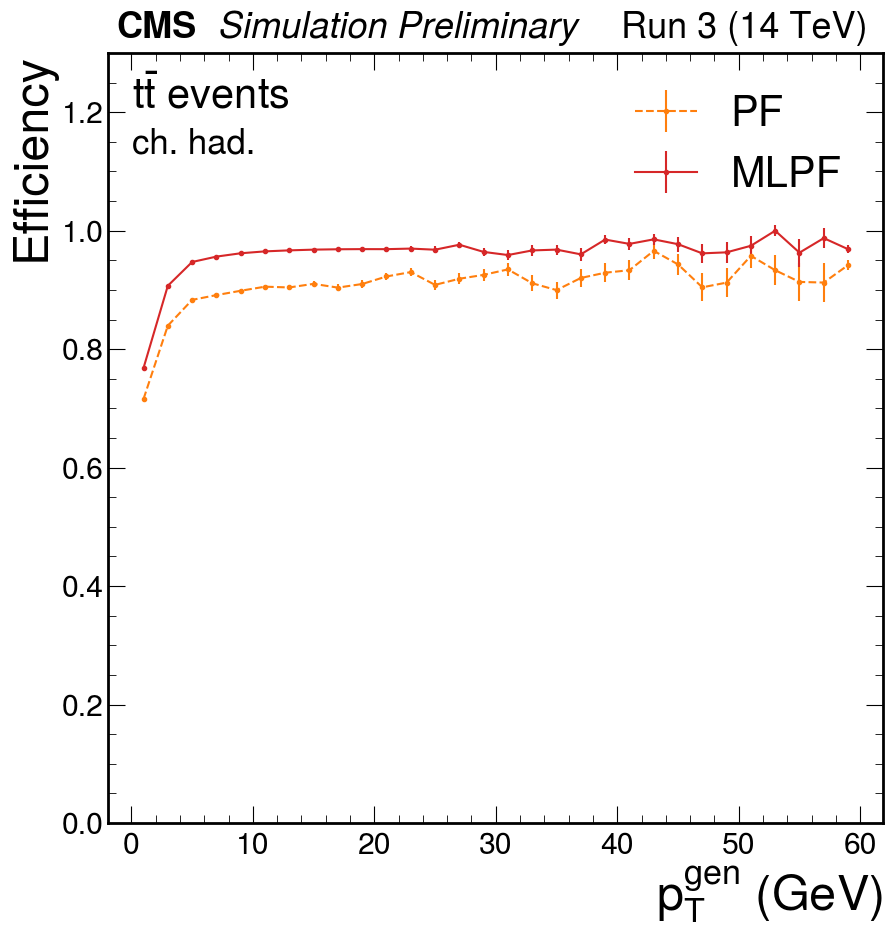

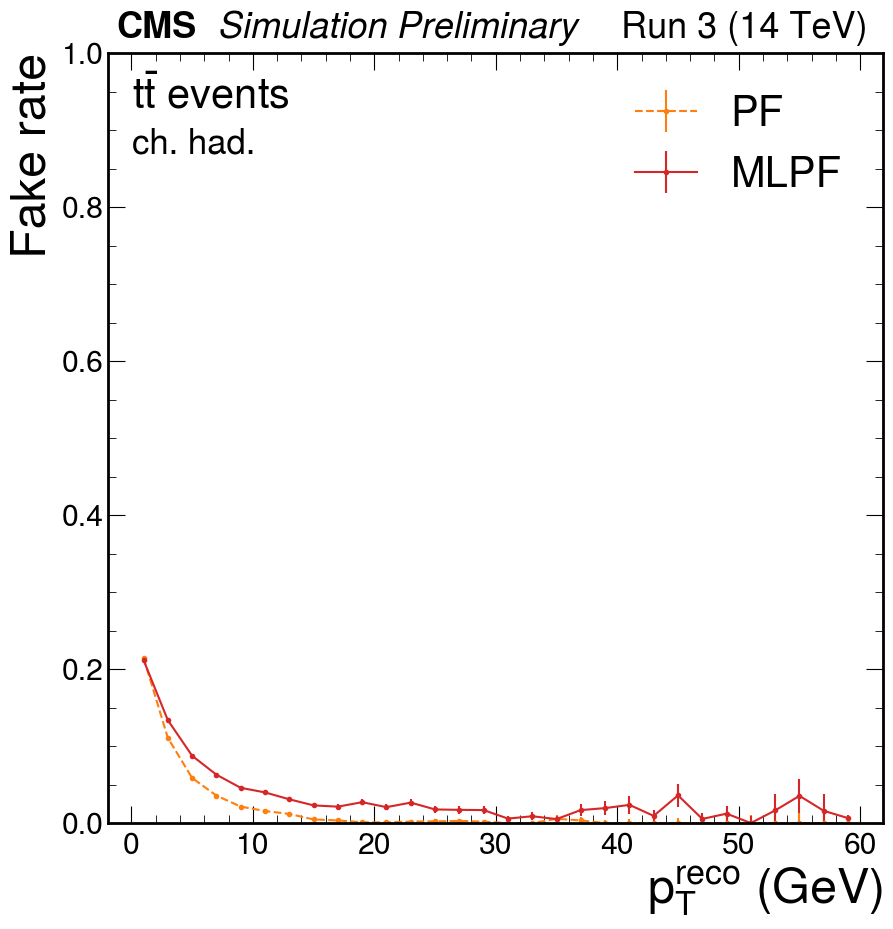

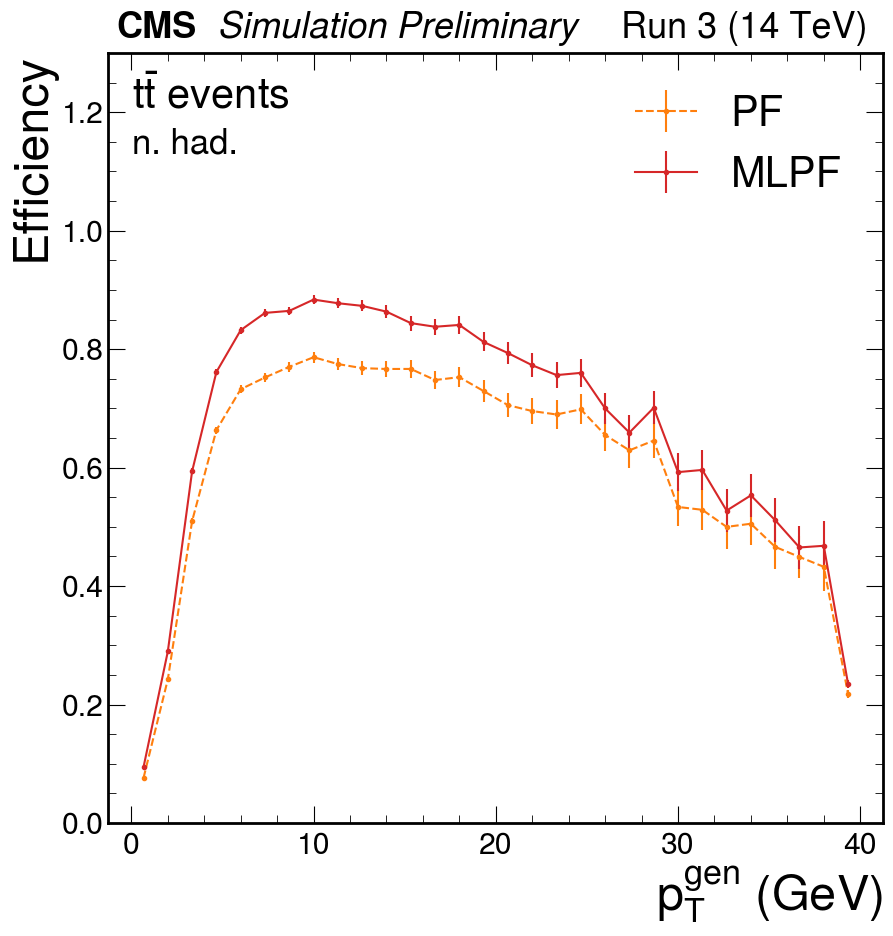

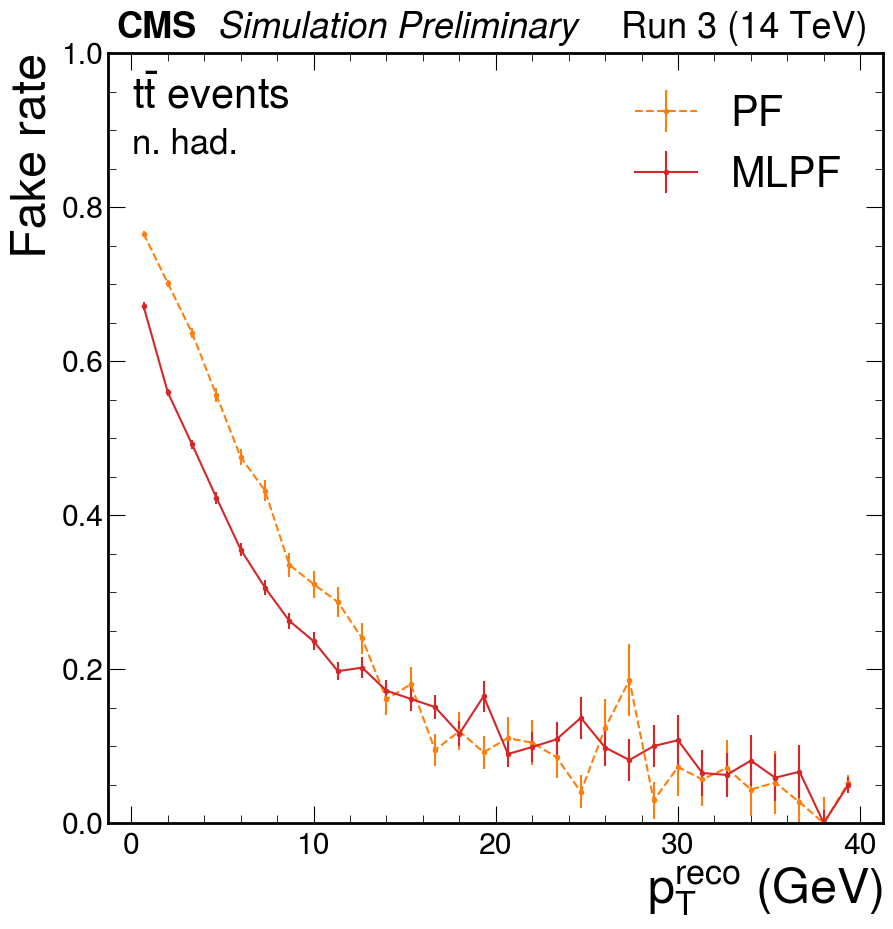

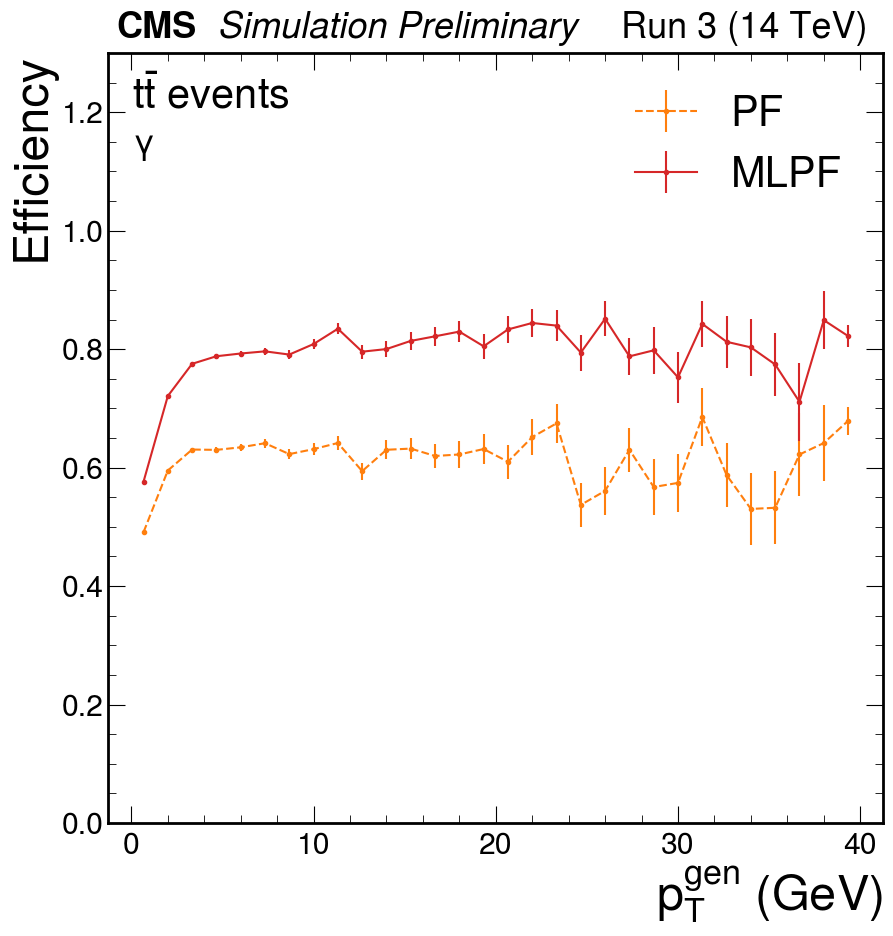

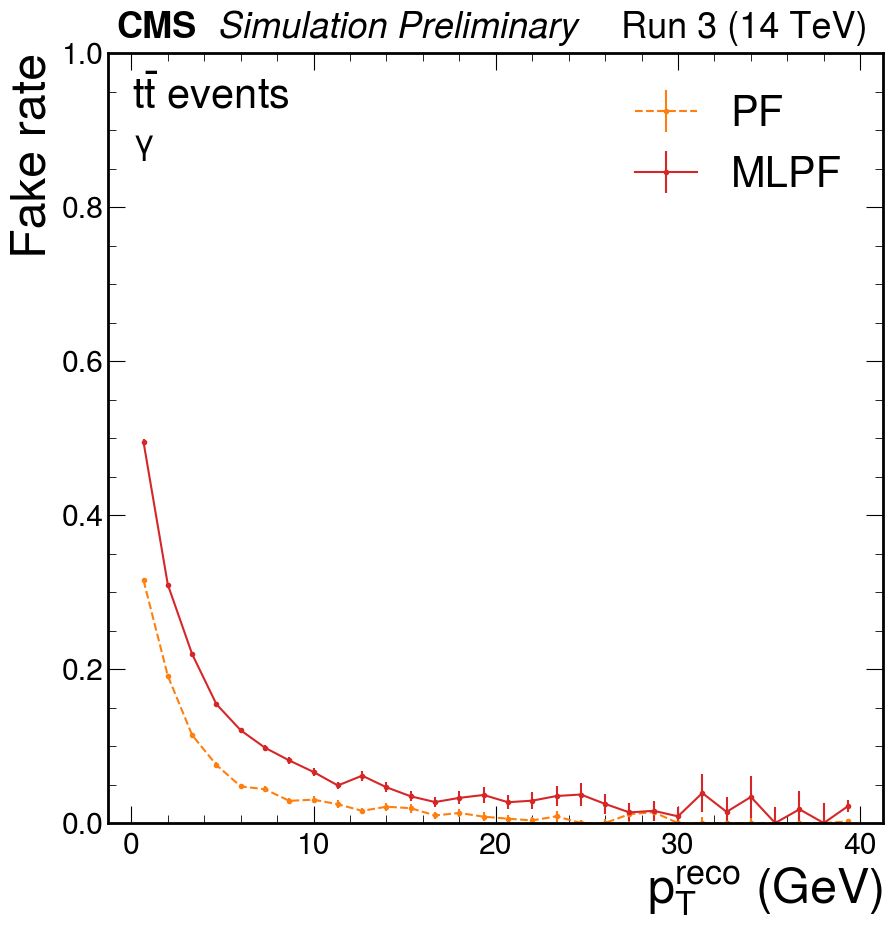

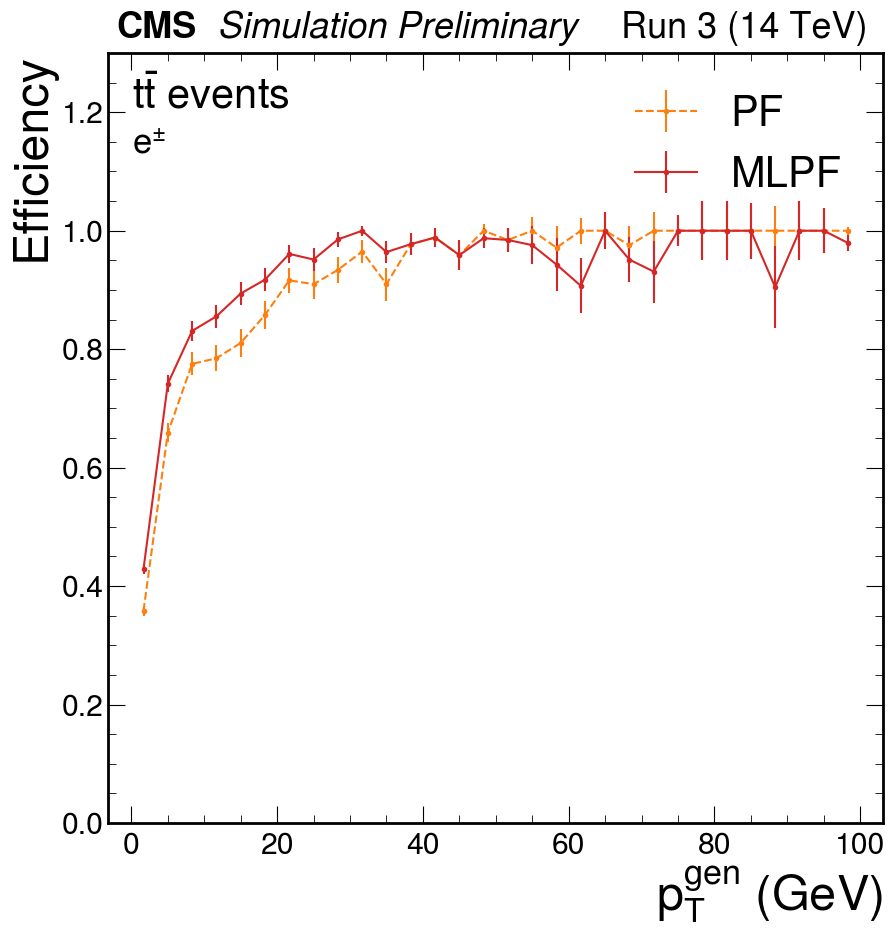

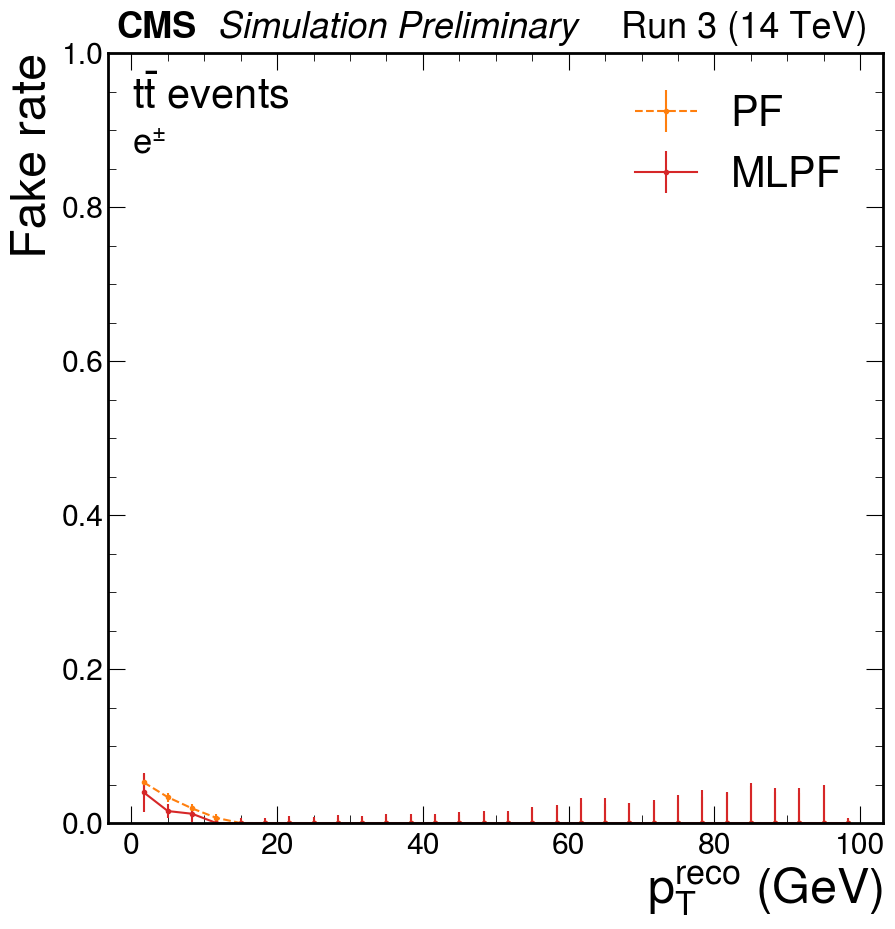

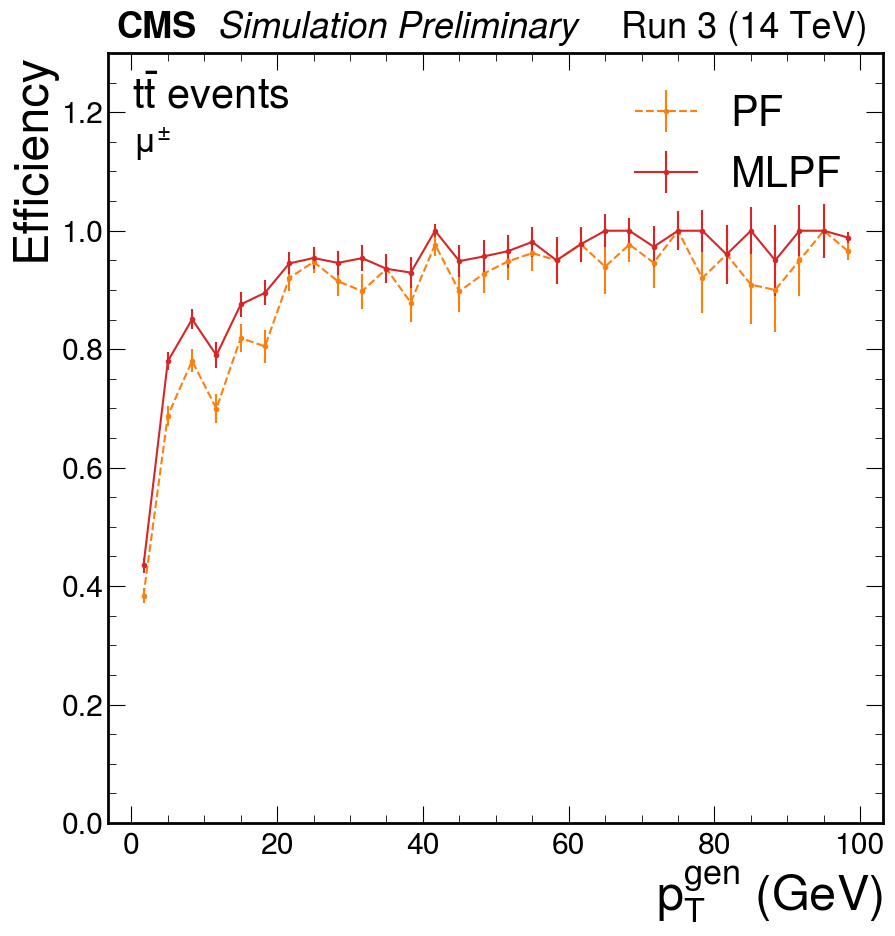

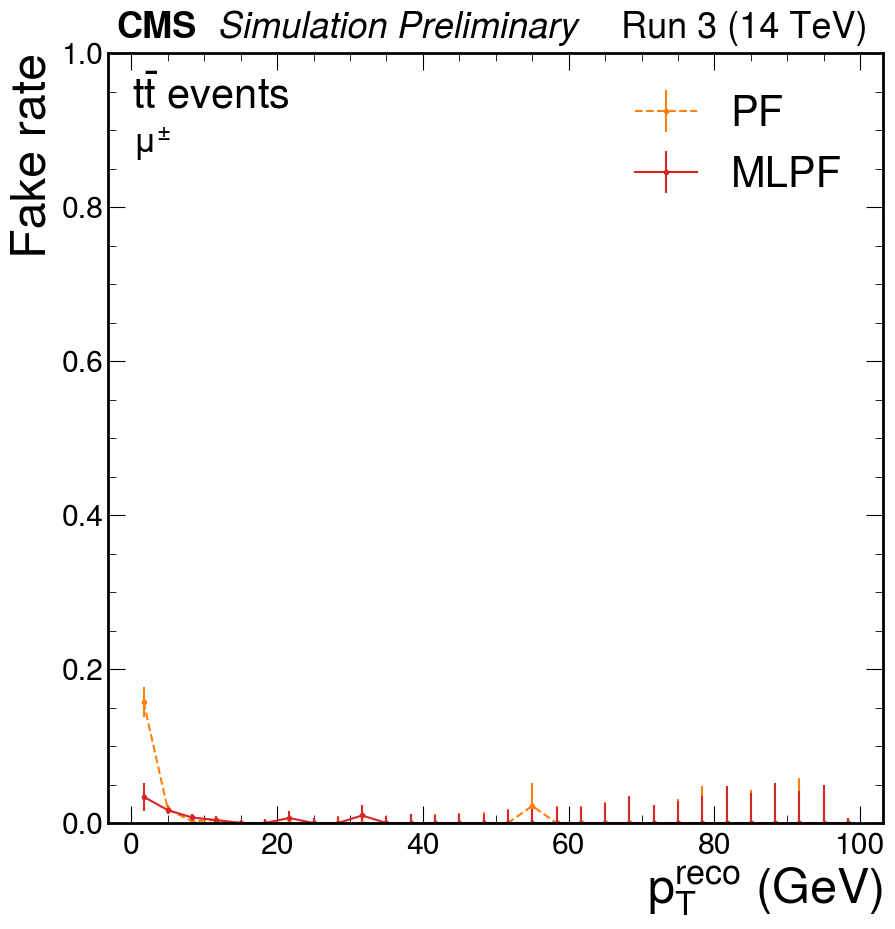

In [23]:
for pid in [
    211,
    130,
    22,
    11,
    13,
]:

    #pick genparticles, and genparticles matched to reco
    h_pf_gen =            to_bh(ak.flatten(data_pf["Gen_pt"][msk_pf_gen][data_pf["Gen_pid"][msk_pf_gen]==pid]), bins=bins_pt[sample][pid])
    h_pf_gen_matched =    to_bh(ak.flatten(data_pf["Gen_pt"][msk_pf_gen][pf_idx1][data_pf["Gen_pid"][msk_pf_gen][pf_idx1]==pid]), bins=bins_pt[sample][pid])

    #pick recoparticles, and recoparticles matched to gen
    h_pf_reco =           to_bh(ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]), bins=bins_pt[sample][pid])
    h_pf_reco_matched =   to_bh(ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][pf_idx2][data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid]), bins=bins_pt[sample][pid])
    
    #repeat for mlpf
    h_mlpf_gen =          to_bh(ak.flatten(data_mlpf["Gen_pt"][msk_mlpf_gen][data_mlpf["Gen_pid"][msk_mlpf_gen]==pid]), bins=bins_pt[sample][pid])
    h_mlpf_gen_matched =  to_bh(ak.flatten(data_mlpf["Gen_pt"][msk_mlpf_gen][mlpf_idx1][data_mlpf["Gen_pid"][msk_mlpf_gen][mlpf_idx1]==pid]), bins=bins_pt[sample][pid])

    h_mlpf_reco =         to_bh(ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]), bins=bins_pt[sample][pid])
    h_mlpf_reco_matched = to_bh(ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2][data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid]), bins=bins_pt[sample][pid])

    #eff: fraction of all gen that were reconstructed
    heff_pf = h_pf_gen_matched/h_pf_gen
    #fake: fraction of all reco that were matched to gen
    hfake_pf = (h_pf_reco - h_pf_reco_matched)/h_pf_reco
    
    heff_mlpf = h_mlpf_gen_matched/h_mlpf_gen
    hfake_mlpf = (h_mlpf_reco - h_mlpf_reco_matched)/h_mlpf_reco
    
    #eff plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(heff_pf.axes[0].edges), heff_pf.values(), binom_error(h_pf_gen_matched.values(), h_pf_gen.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    
    plt.errorbar(
        midpoints(heff_mlpf.axes[0].edges), heff_mlpf.values(), binom_error(h_mlpf_gen_matched.values(), h_mlpf_gen.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.3)
    plt.ylabel("Efficiency", fontsize=35)
    plt.xlabel("$p_T^{gen}$ (GeV)", fontsize=35)
    plt.legend(loc="best", fontsize=30)
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)
    
    plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt/{sample}_efficiency_pt_{pid}_with_missing_genparts.pdf")
    
    #fake plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(hfake_pf.axes[0].edges), hfake_pf.values(), binom_error(h_pf_reco_matched.values(), h_pf_reco.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    plt.errorbar(
        midpoints(hfake_mlpf.axes[0].edges), hfake_mlpf.values(), binom_error(h_mlpf_reco_matched.values(), h_mlpf_reco.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.0)
    plt.ylabel("Fake rate", fontsize=35)
    plt.xlabel("$p_T^{reco}$ (GeV)", fontsize=35)
    plt.legend(loc="best", fontsize=30)
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)
    
    plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt/{sample}_fakerate_pt_{pid}_with_missing_genparts.pdf")

# eta

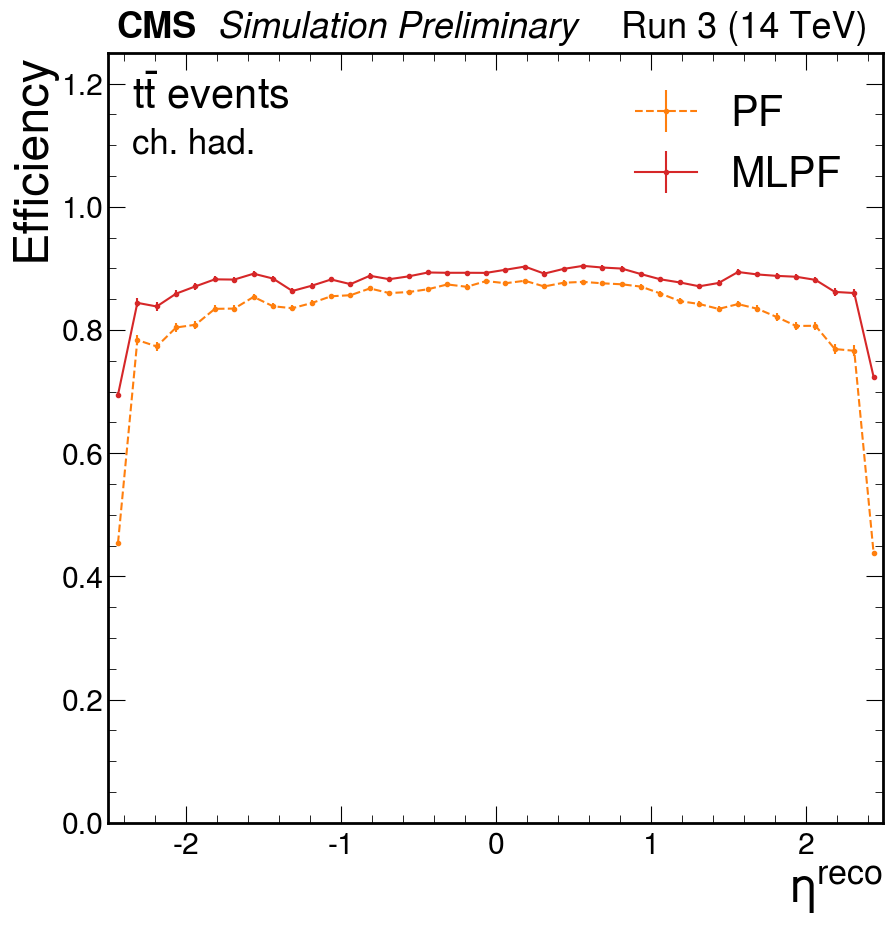

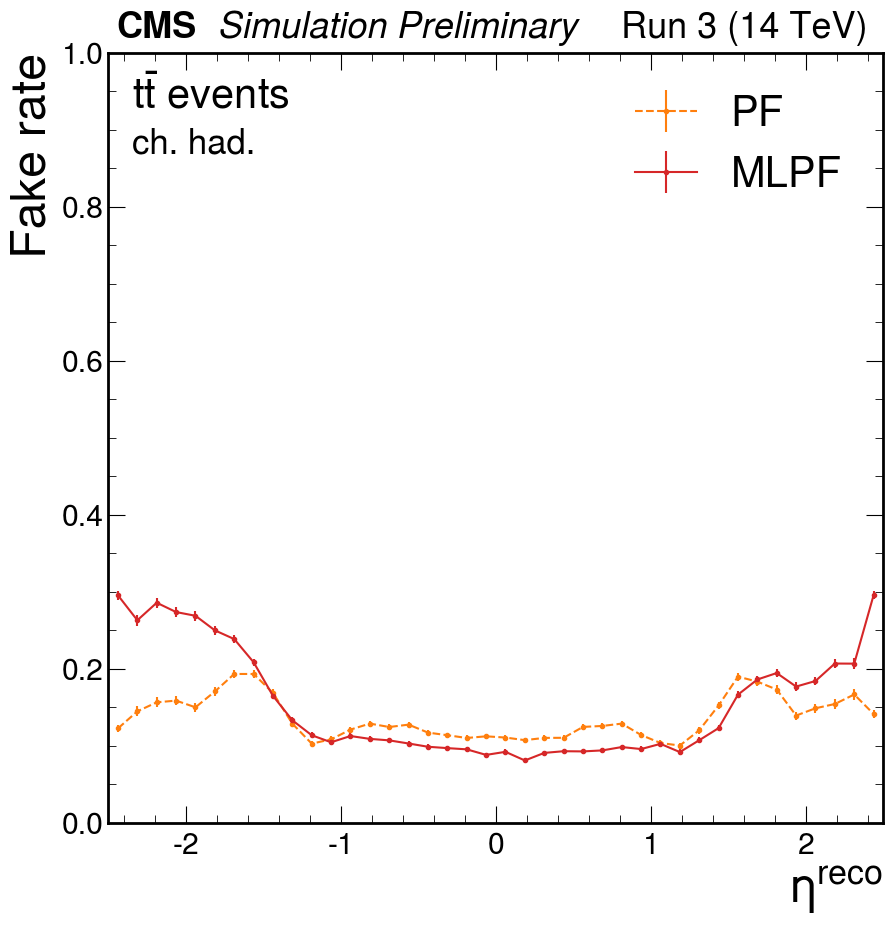

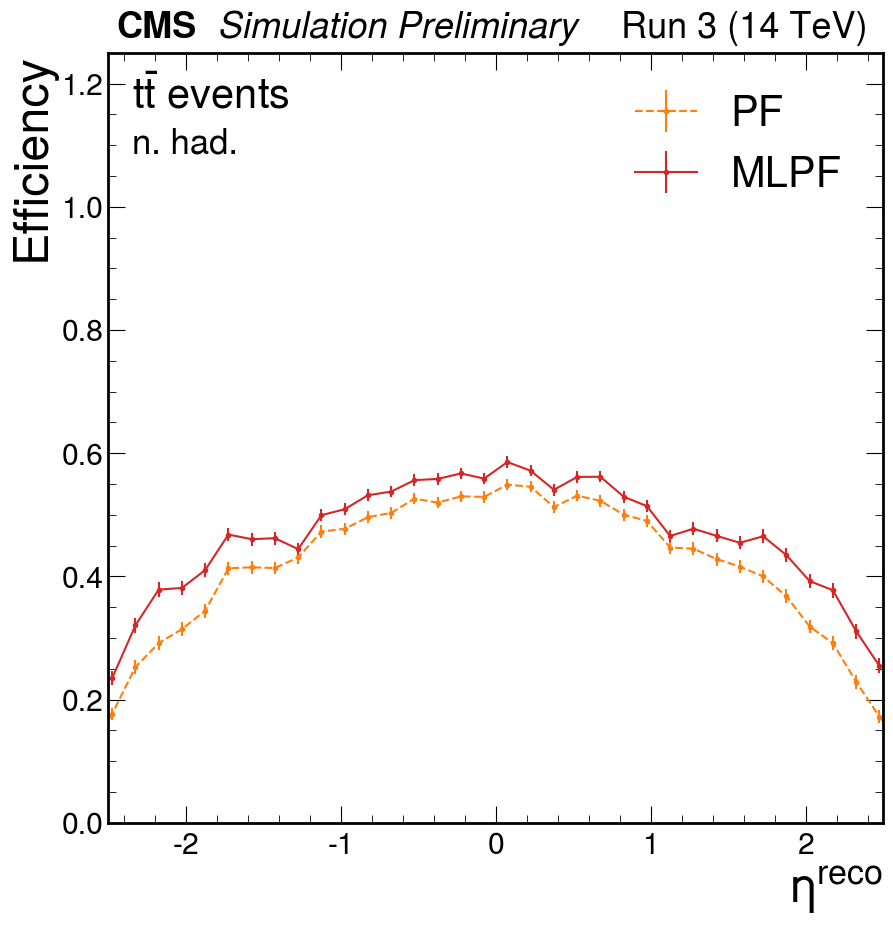

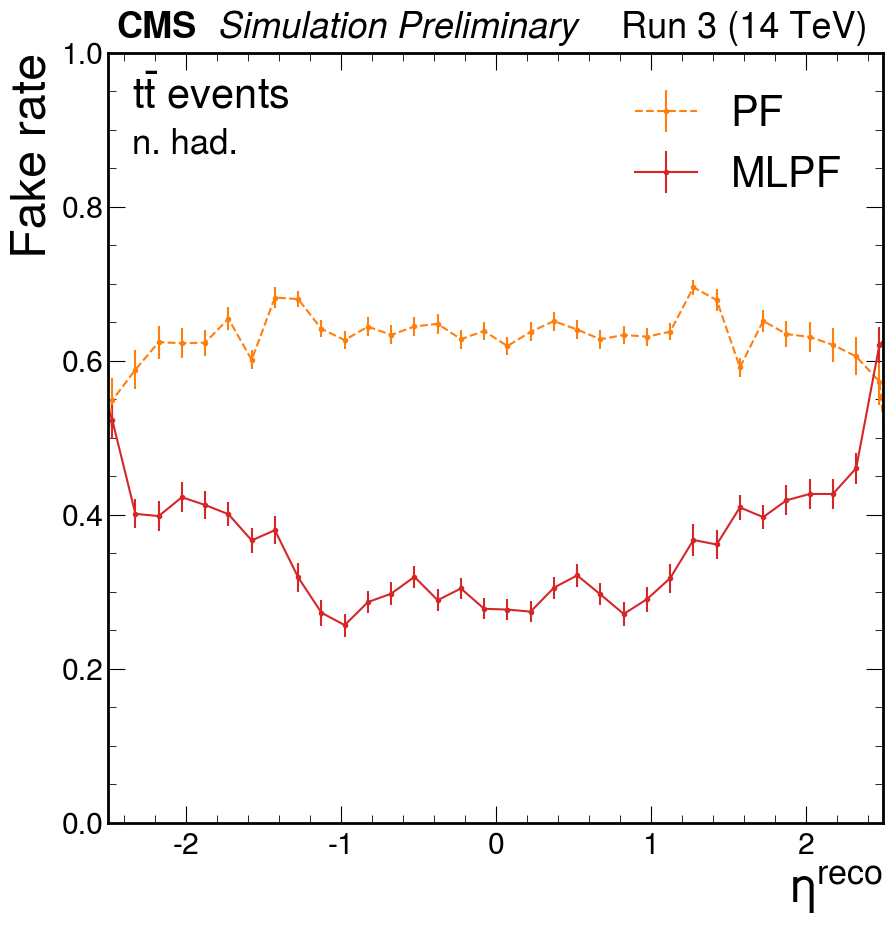

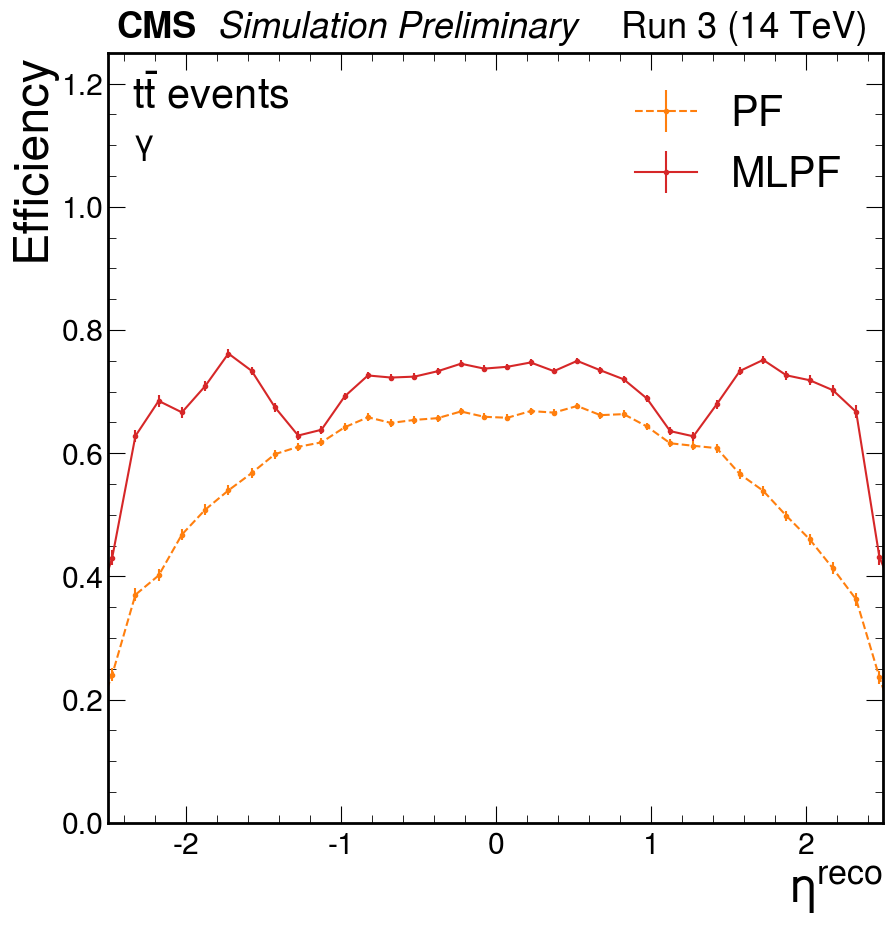

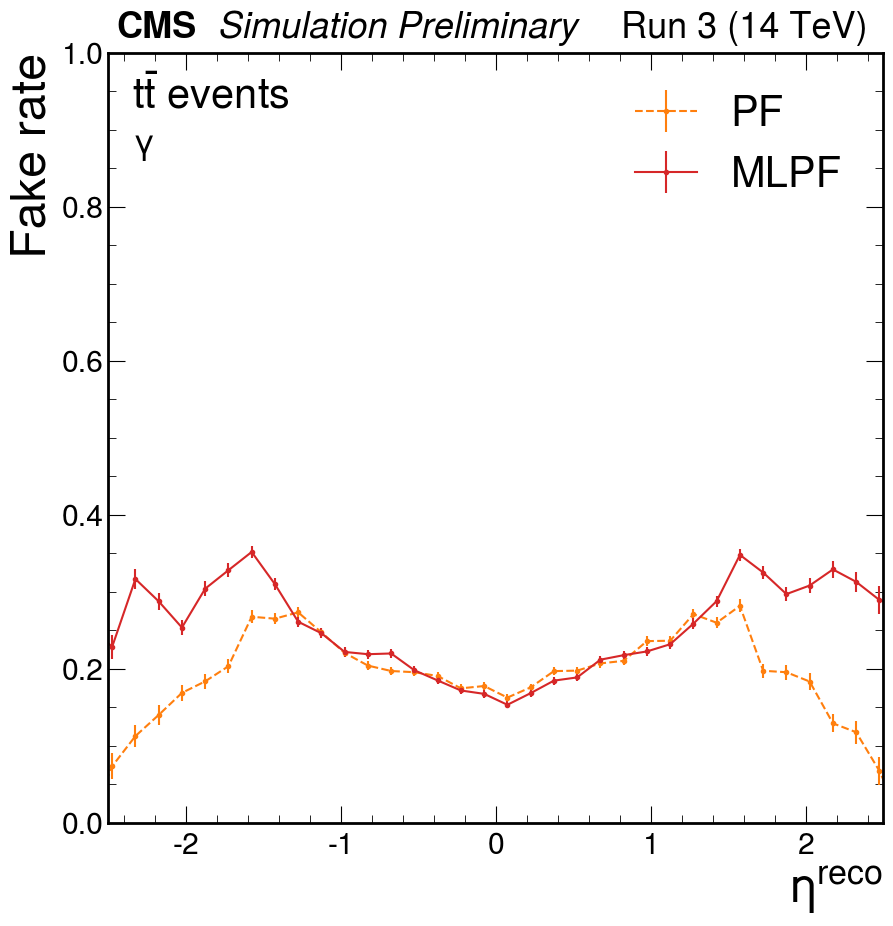

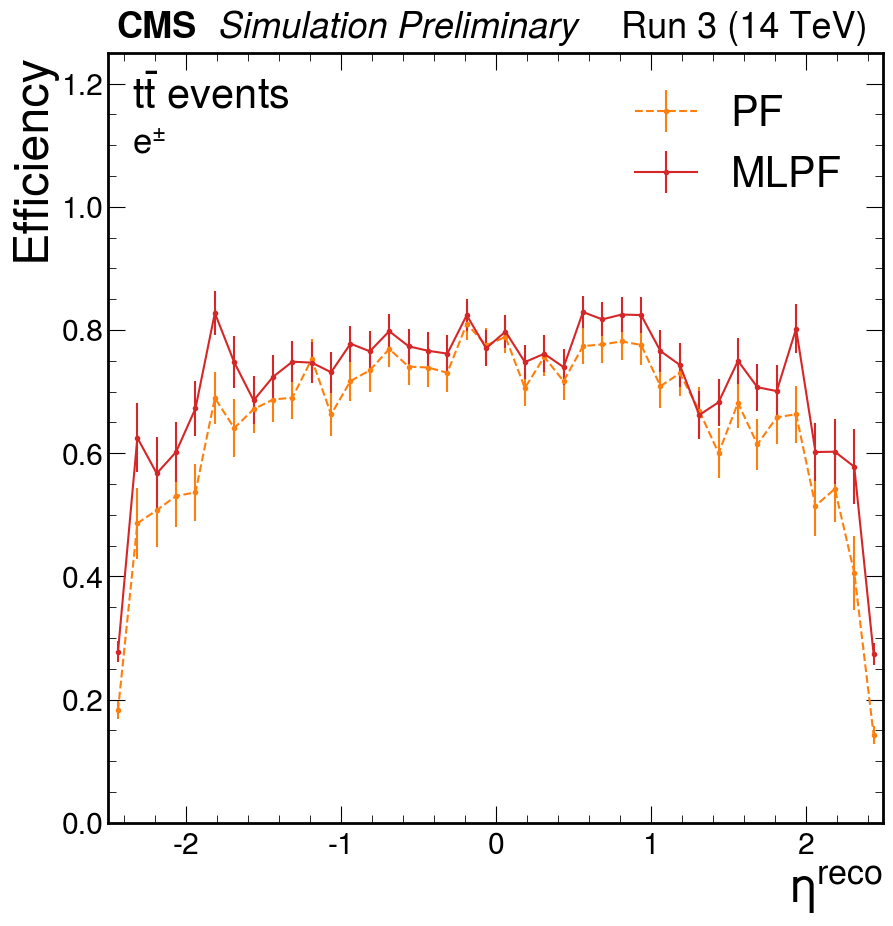

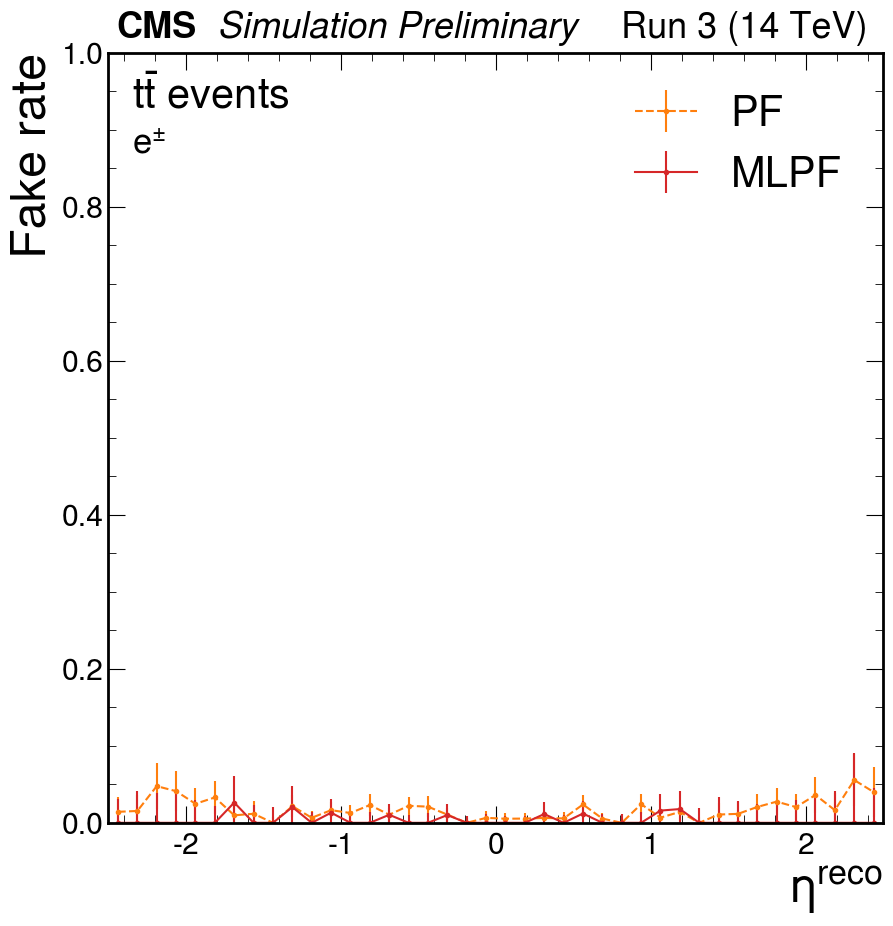

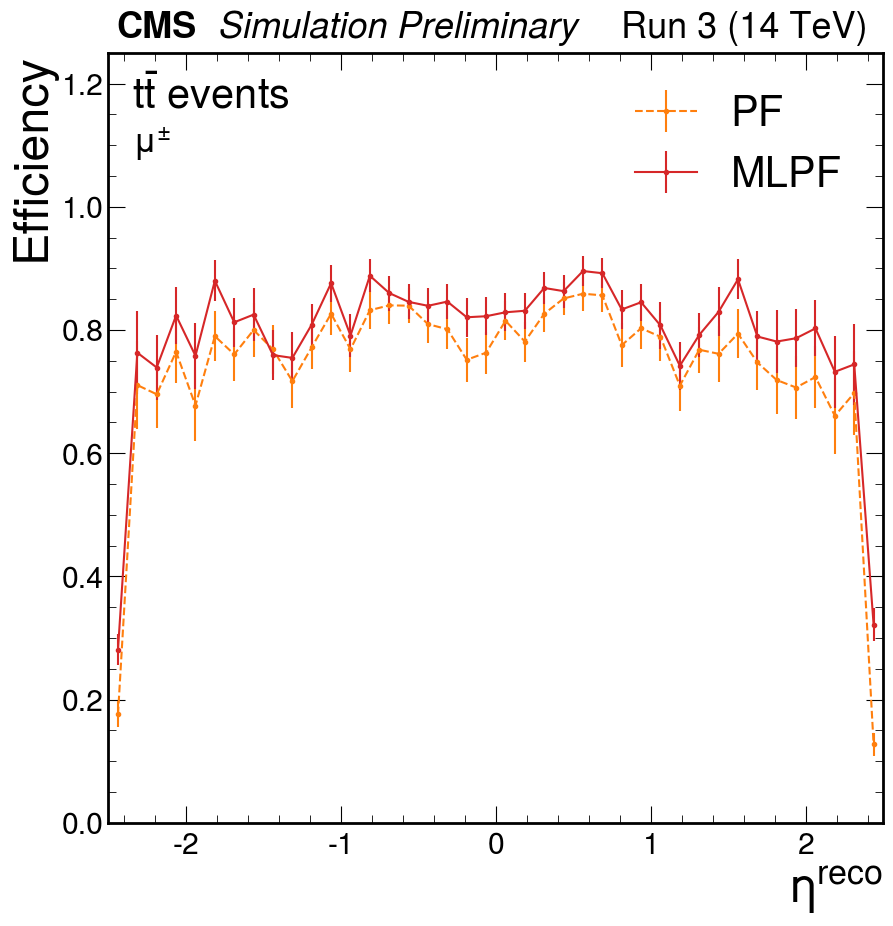

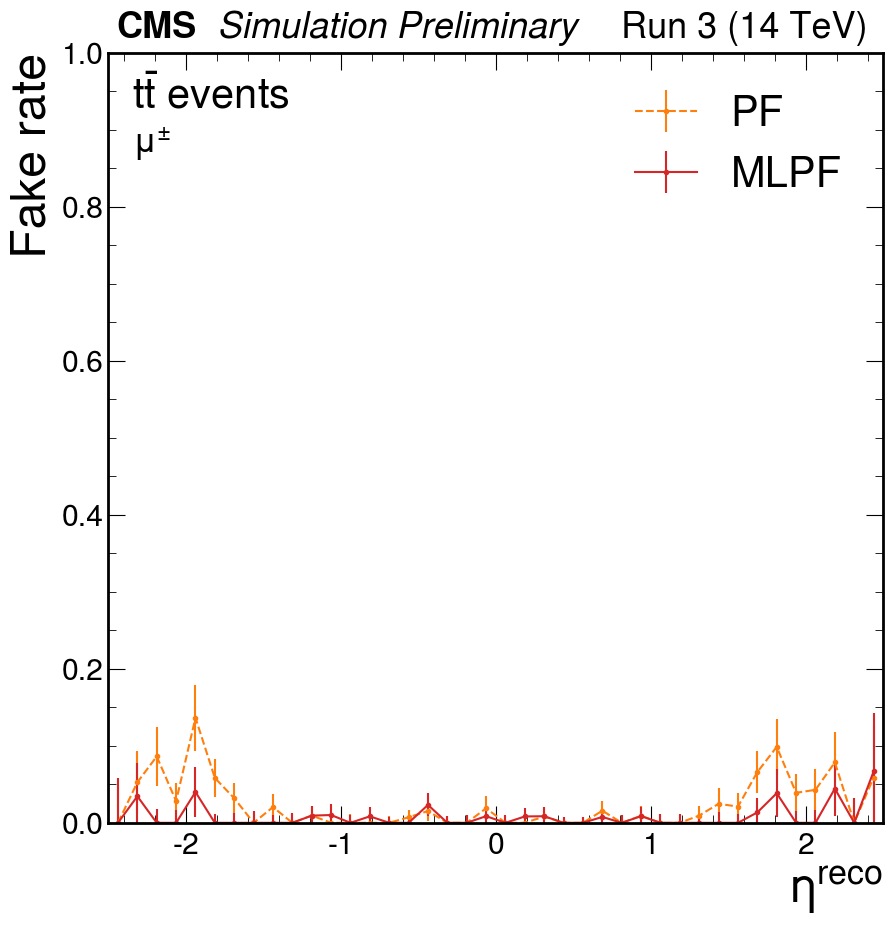

In [24]:
for pid in [
    211,
    130,
    22,
    11,
    13,
]:

    #pick genparticles, and genparticles matched to reco
    h_pf_gen =            to_bh(ak.flatten(data_pf["Gen_eta"][msk_pf_gen][data_pf["Gen_pid"][msk_pf_gen]==pid]), bins=bins_eta[sample][pid])
    h_pf_gen_matched =    to_bh(ak.flatten(data_pf["Gen_eta"][msk_pf_gen][pf_idx1][data_pf["Gen_pid"][msk_pf_gen][pf_idx1]==pid]), bins=bins_eta[sample][pid])

    #pick recoparticles, and recoparticles matched to gen
    h_pf_reco =           to_bh(ak.flatten(data_pf["PFCands_eta"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]), bins=bins_eta[sample][pid])
    h_pf_reco_matched =   to_bh(ak.flatten(data_pf["PFCands_eta"][msk_pf_reco][pf_idx2][data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid]), bins=bins_eta[sample][pid])

    #repeat for mlpf
    h_mlpf_gen =          to_bh(ak.flatten(data_mlpf["Gen_eta"][msk_mlpf_gen][data_mlpf["Gen_pid"][msk_mlpf_gen]==pid]), bins=bins_eta[sample][pid])
    h_mlpf_gen_matched =  to_bh(ak.flatten(data_mlpf["Gen_eta"][msk_mlpf_gen][mlpf_idx1][data_mlpf["Gen_pid"][msk_mlpf_gen][mlpf_idx1]==pid]), bins=bins_eta[sample][pid])
    h_mlpf_reco =         to_bh(ak.flatten(data_mlpf["PFCands_eta"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]), bins=bins_eta[sample][pid])
    h_mlpf_reco_matched = to_bh(ak.flatten(data_mlpf["PFCands_eta"][msk_mlpf_reco][mlpf_idx2][data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid]), bins=bins_eta[sample][pid])

    #eff: fraction of all gen that were reconstructed
    heff_pf = h_pf_gen_matched/h_pf_gen
    #fake: fraction of all reco that were matched to gen
    hfake_pf = (h_pf_reco - h_pf_reco_matched)/h_pf_reco
    
    heff_mlpf = h_mlpf_gen_matched/h_mlpf_gen
    hfake_mlpf = (h_mlpf_reco - h_mlpf_reco_matched)/h_mlpf_reco
    
    #eff plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(heff_pf.axes[0].edges), heff_pf.values(), binom_error(h_pf_gen_matched.values(), h_pf_gen.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    
    plt.errorbar(
        midpoints(heff_mlpf.axes[0].edges), heff_mlpf.values(), binom_error(h_mlpf_gen_matched.values(), h_mlpf_gen.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.25)
    plt.xlim(-2.5, 2.5)    
    plt.ylabel("Efficiency", fontsize=35)
    plt.xlabel("$\eta^{reco}$", fontsize=35)
    plt.legend(loc="best", fontsize=30)
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)
        
    plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_eta/{sample}_efficiency_eta_{pid}_with_missing_genparts.pdf")
    
    #fake plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(hfake_pf.axes[0].edges), hfake_pf.values(), binom_error(h_pf_reco_matched.values(), h_pf_reco.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    plt.errorbar(
        midpoints(hfake_mlpf.axes[0].edges), hfake_mlpf.values(), binom_error(h_mlpf_reco_matched.values(), h_mlpf_reco.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.0)
    plt.xlim(-2.5, 2.5)
    plt.ylabel("Fake rate", fontsize=35)
    plt.xlabel("$\eta^{reco}$", fontsize=35)
    plt.legend(loc="best", fontsize=30)
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)
    
    plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_eta/{sample}_fakerate_eta_{pid}_with_missing_genparts.pdf")

# phi

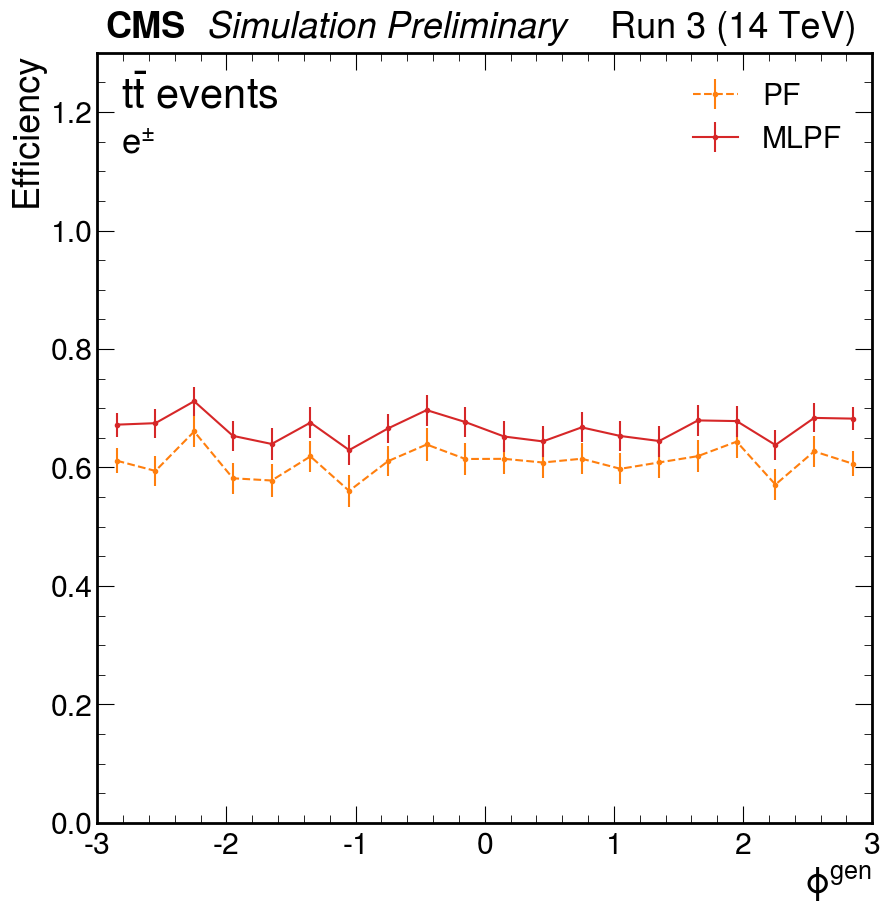

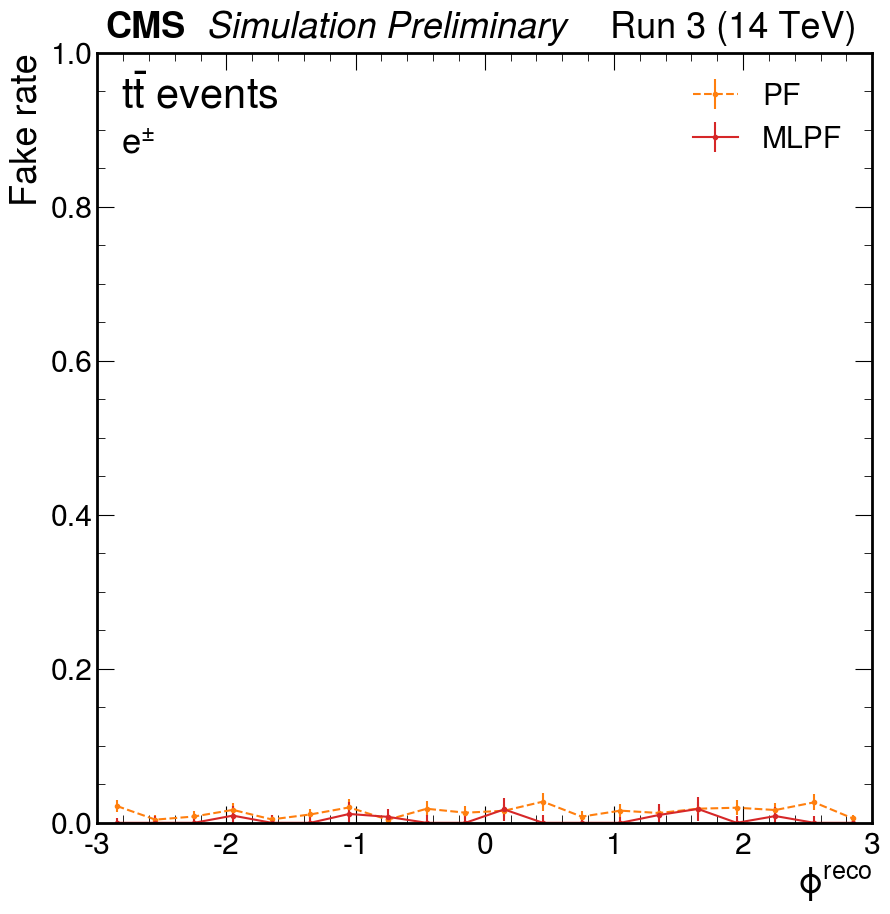

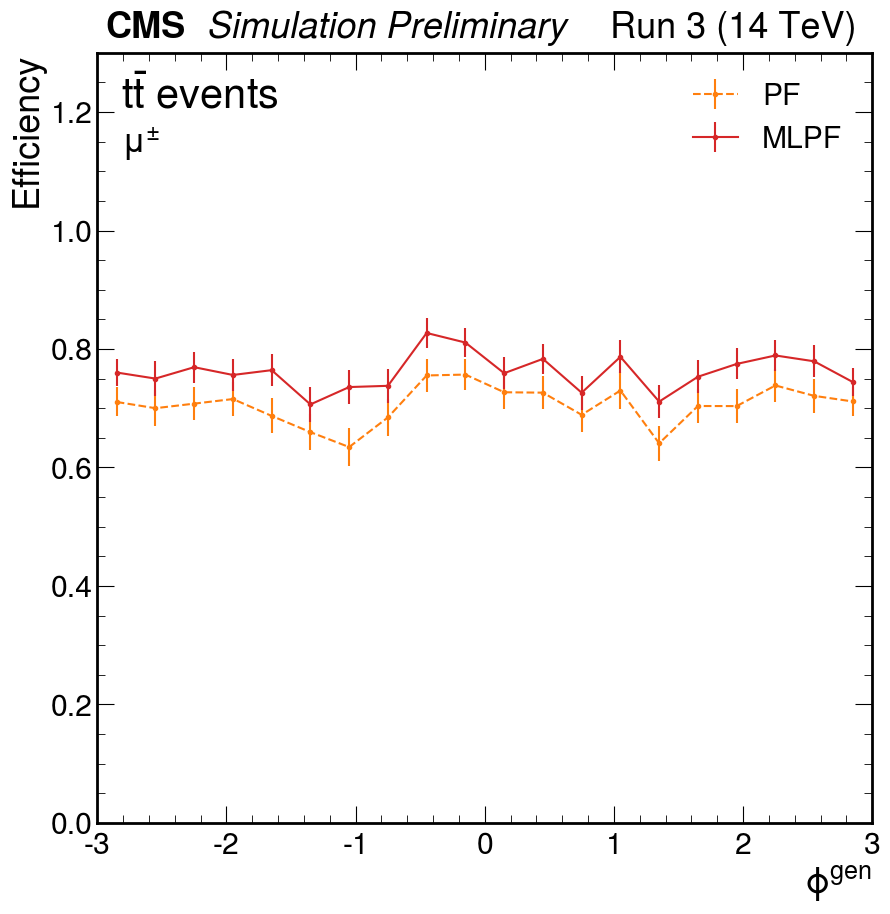

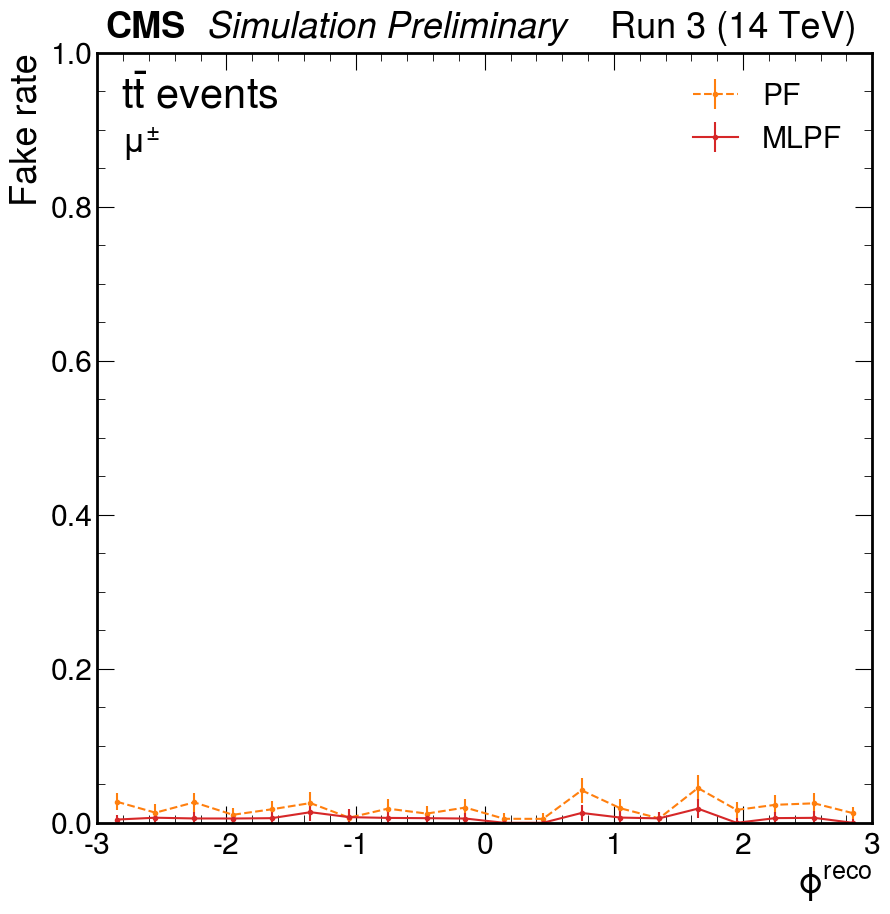

In [25]:
for pid in [
#     211,
#     130,
#     22,
    11,
    13,
]:

    #pick genparticles, and genparticles matched to reco
    h_pf_gen =            to_bh(ak.flatten(data_pf["Gen_phi"][msk_pf_gen][data_pf["Gen_pid"][msk_pf_gen]==pid]), bins=bins_phi[sample][pid])
    h_pf_gen_matched =    to_bh(ak.flatten(data_pf["Gen_phi"][msk_pf_gen][pf_idx1][data_pf["Gen_pid"][msk_pf_gen][pf_idx1]==pid]), bins=bins_phi[sample][pid])

    #pick recoparticles, and recoparticles matched to gen
    h_pf_reco =           to_bh(ak.flatten(data_pf["PFCands_phi"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]), bins=bins_phi[sample][pid])
    h_pf_reco_matched =   to_bh(ak.flatten(data_pf["PFCands_phi"][msk_pf_reco][pf_idx2][data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid]), bins=bins_phi[sample][pid])

    #repeat for mlpf
    h_mlpf_gen =          to_bh(ak.flatten(data_mlpf["Gen_phi"][msk_mlpf_gen][data_mlpf["Gen_pid"][msk_mlpf_gen]==pid]), bins=bins_phi[sample][pid])
    h_mlpf_gen_matched =  to_bh(ak.flatten(data_mlpf["Gen_phi"][msk_mlpf_gen][mlpf_idx1][data_mlpf["Gen_pid"][msk_mlpf_gen][mlpf_idx1]==pid]), bins=bins_phi[sample][pid])
    h_mlpf_reco =         to_bh(ak.flatten(data_mlpf["PFCands_phi"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]), bins=bins_phi[sample][pid])
    h_mlpf_reco_matched = to_bh(ak.flatten(data_mlpf["PFCands_phi"][msk_mlpf_reco][mlpf_idx2][data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid]), bins=bins_phi[sample][pid])

    #eff: fraction of all gen that were reconstructed
    heff_pf = h_pf_gen_matched/h_pf_gen
    #fake: fraction of all reco that were matched to gen
    hfake_pf = (h_pf_reco - h_pf_reco_matched)/h_pf_reco
    
    heff_mlpf = h_mlpf_gen_matched/h_mlpf_gen
    hfake_mlpf = (h_mlpf_reco - h_mlpf_reco_matched)/h_mlpf_reco
    
    #eff plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(heff_pf.axes[0].edges), heff_pf.values(), binom_error(h_pf_gen_matched.values(), h_pf_gen.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    
    plt.errorbar(
        midpoints(heff_mlpf.axes[0].edges), heff_mlpf.values(), binom_error(h_mlpf_gen_matched.values(), h_mlpf_gen.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.3)
    plt.xlim(-3, 3)     
    plt.ylabel("Efficiency")
    plt.xlabel("$\phi^{gen}$")
    plt.legend(loc="best")
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)    
    
    plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_phi/{sample}_efficiency_phi_{pid}_with_missing_genparts.pdf")
    
    #fake plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(hfake_pf.axes[0].edges), hfake_pf.values(), binom_error(h_pf_reco_matched.values(), h_pf_reco.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    plt.errorbar(
        midpoints(hfake_mlpf.axes[0].edges), hfake_mlpf.values(), binom_error(h_mlpf_reco_matched.values(), h_mlpf_reco.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1)
    plt.xlim(-3, 3)    
    plt.ylabel("Fake rate")
    plt.xlabel("$\phi^{reco}$")
    plt.legend(loc="best")
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)    
    
    plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_phi/{sample}_fakerate_phi_{pid}_with_missing_genparts.pdf")

# pT resolution

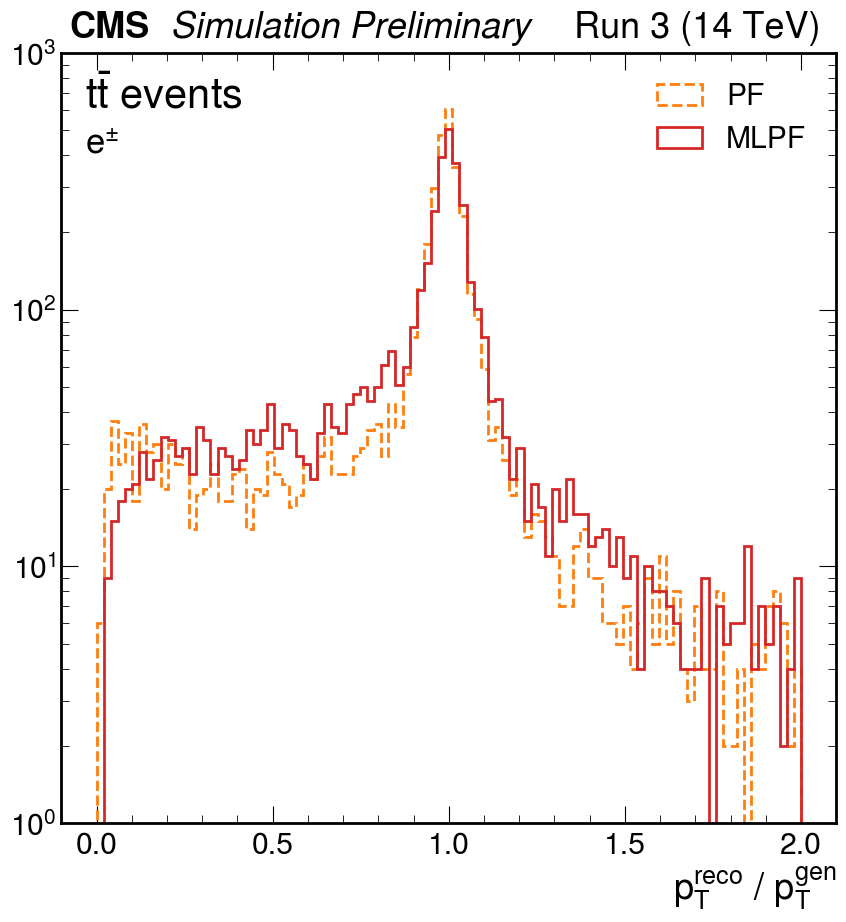

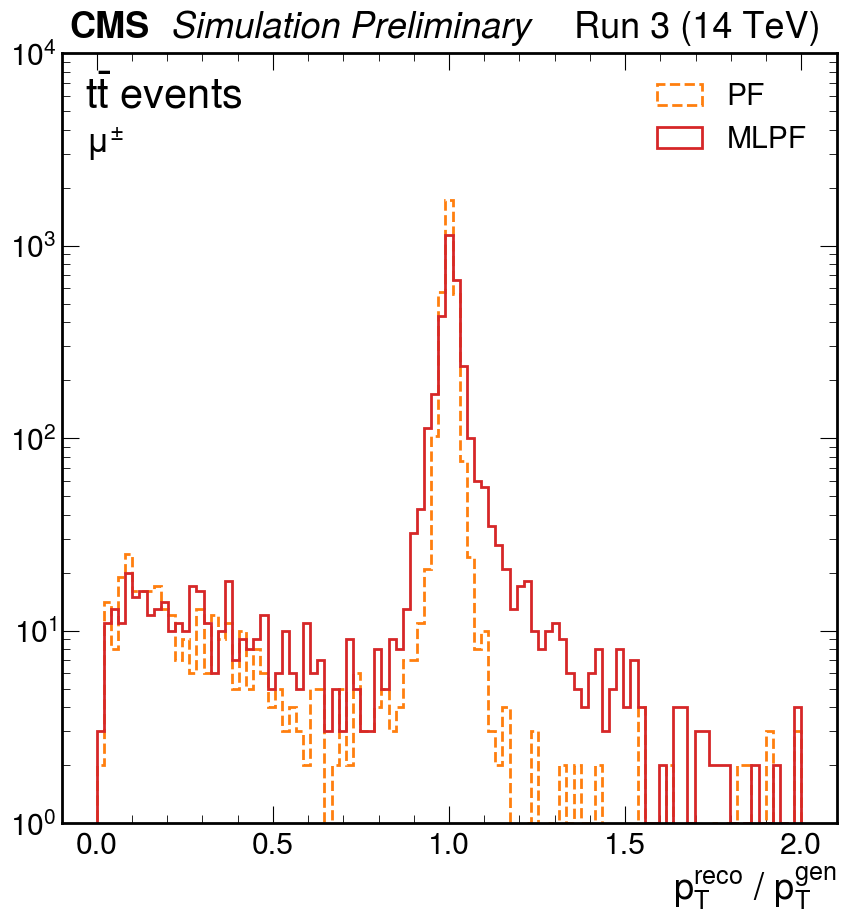

In [26]:
b_dict = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(0,10,200),
        130: np.linspace(0,10,200),
        22: np.linspace(0,20,200),
        11: np.linspace(0,5,100),
        13: np.linspace(0,2,100),
    },    
    "cms_pf_ttbar_nopu": {
        211: np.linspace(0,10,200),
        130: np.linspace(0,10,200),
        22: np.linspace(0,10,200),
        11: np.linspace(0,2,100),
        13: np.linspace(0,2,100),
    },    
}

ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: 10**8,
        130: 10**5,
        22: 10**6,
        11: 10**4,
        13: 10**4,
    },    
    "cms_pf_ttbar_nopu": {
        211: 10**6,
        130: 10**4,
        22: 10**5,
        11: 10**3,
        13: 10**4,
    },    
}

for pid in [
#     211,
#     130,
#     22,
    11,
    13,
]:
    
    fig = plt.figure()
    ax = plt.axes()
    plt.hist(ak.flatten((data_pf["PFCands_pt"][msk_pf_reco][pf_idx2]/data_pf["Gen_pt"][msk_pf_gen][pf_idx1])[data_pf["Gen_pid"][msk_pf_gen][pf_idx1]==pid]), bins=b_dict[sample][pid], histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"]);
    plt.hist(ak.flatten((data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2]/data_mlpf["Gen_pt"][msk_mlpf_gen][mlpf_idx1])[data_mlpf["Gen_pid"][msk_mlpf_gen][mlpf_idx1]==pid]), bins=b_dict[sample][pid], histtype="step",lw=2, label="MLPF", color=color_code["MLPF"]);
    plt.yscale("log")
    plt.ylim(1, ylim_dict[sample][pid])
    plt.xlabel("$p_T^{reco}$ / $p_T^{gen}$")
    plt.legend()
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)
    
    plt.savefig(f"./plots/{save_as[sample]}/particle_ptres/{sample}_ptres_{pid}_with_missing_genparts.pdf")